In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
track_length = 200.  # cm
run_vel = 20.  # cm/s
ramp_scaling_factor = 0.2308028752748705

In [4]:
position = np.linspace(0., track_length, 100, endpoint=False)

In [5]:
t = position / run_vel

In [6]:
field_width = 90.  # cm
pre_rate = np.exp(-0.5 * ((track_length / 2. - position)/(field_width / 6.))**2.)

<IPython.core.display.Javascript object>


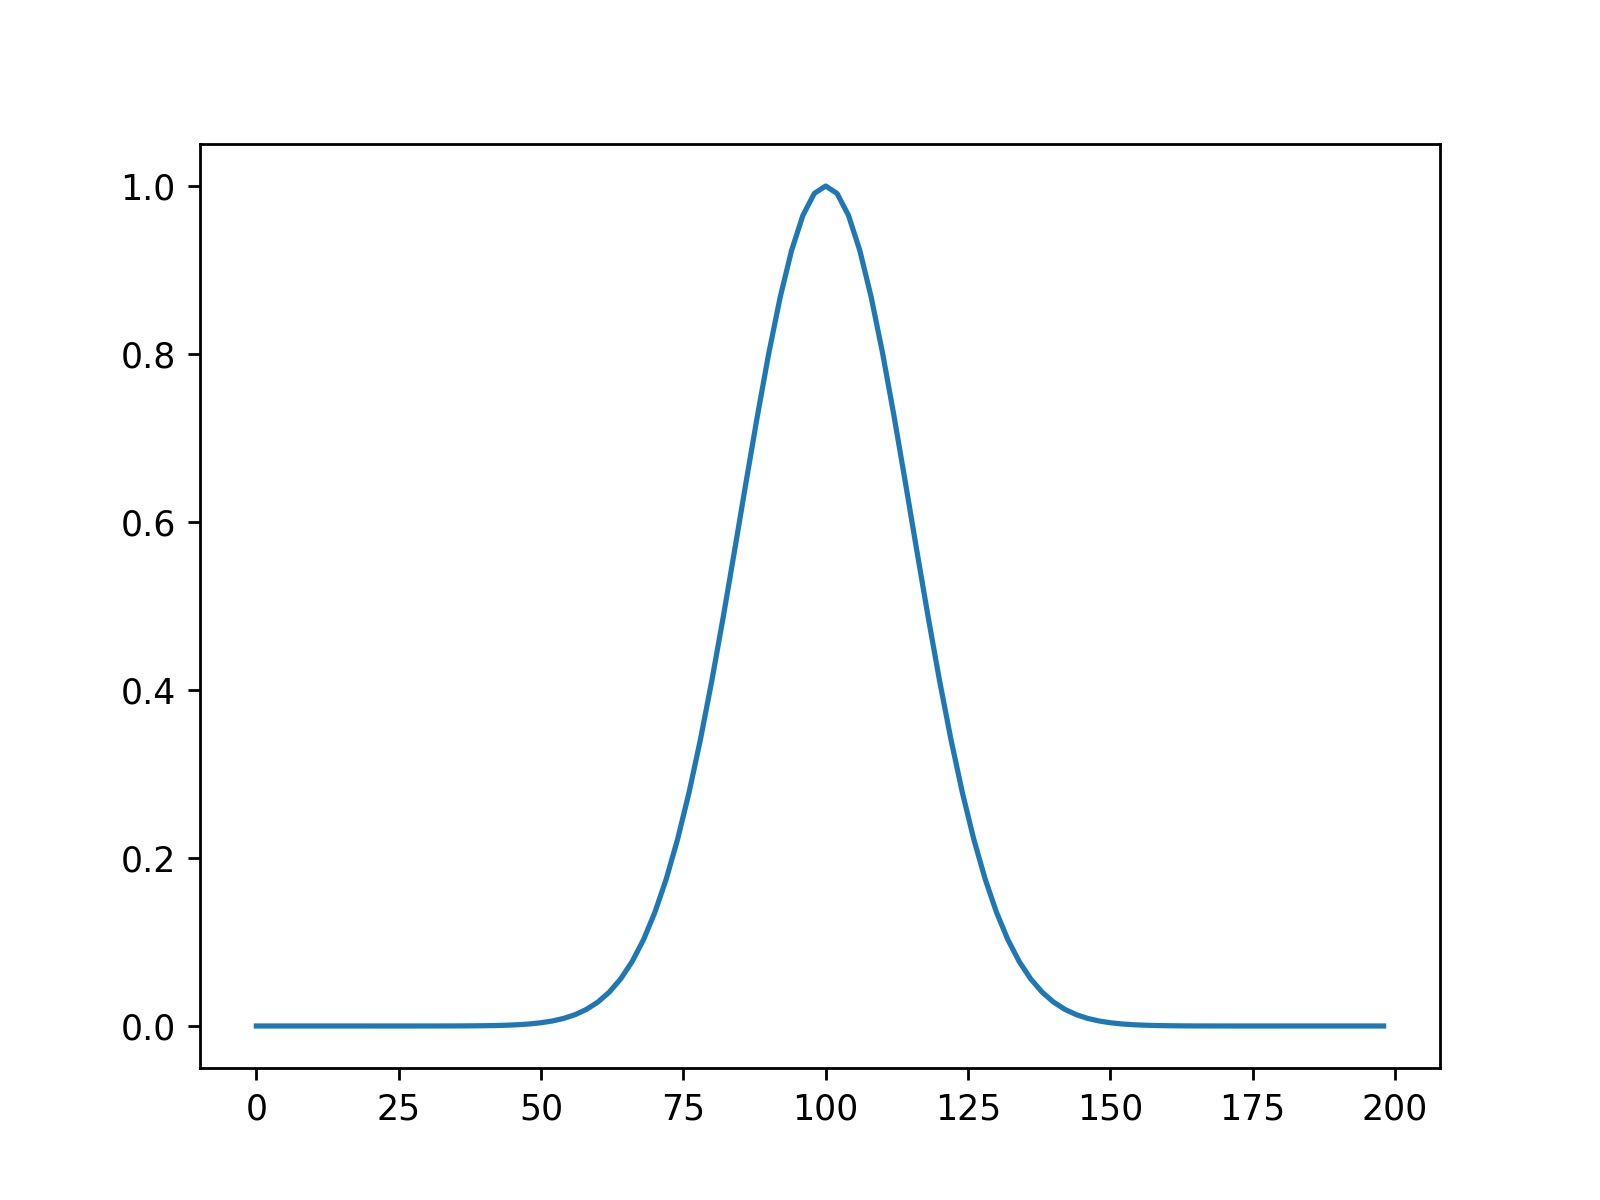

In [7]:
plt.figure()
plt.plot(position, pre_rate)

In [8]:
pre_rate = lambda peak_loc: np.exp(-0.5 * ((peak_loc - position)/(field_width / 6.))**2.)

<IPython.core.display.Javascript object>


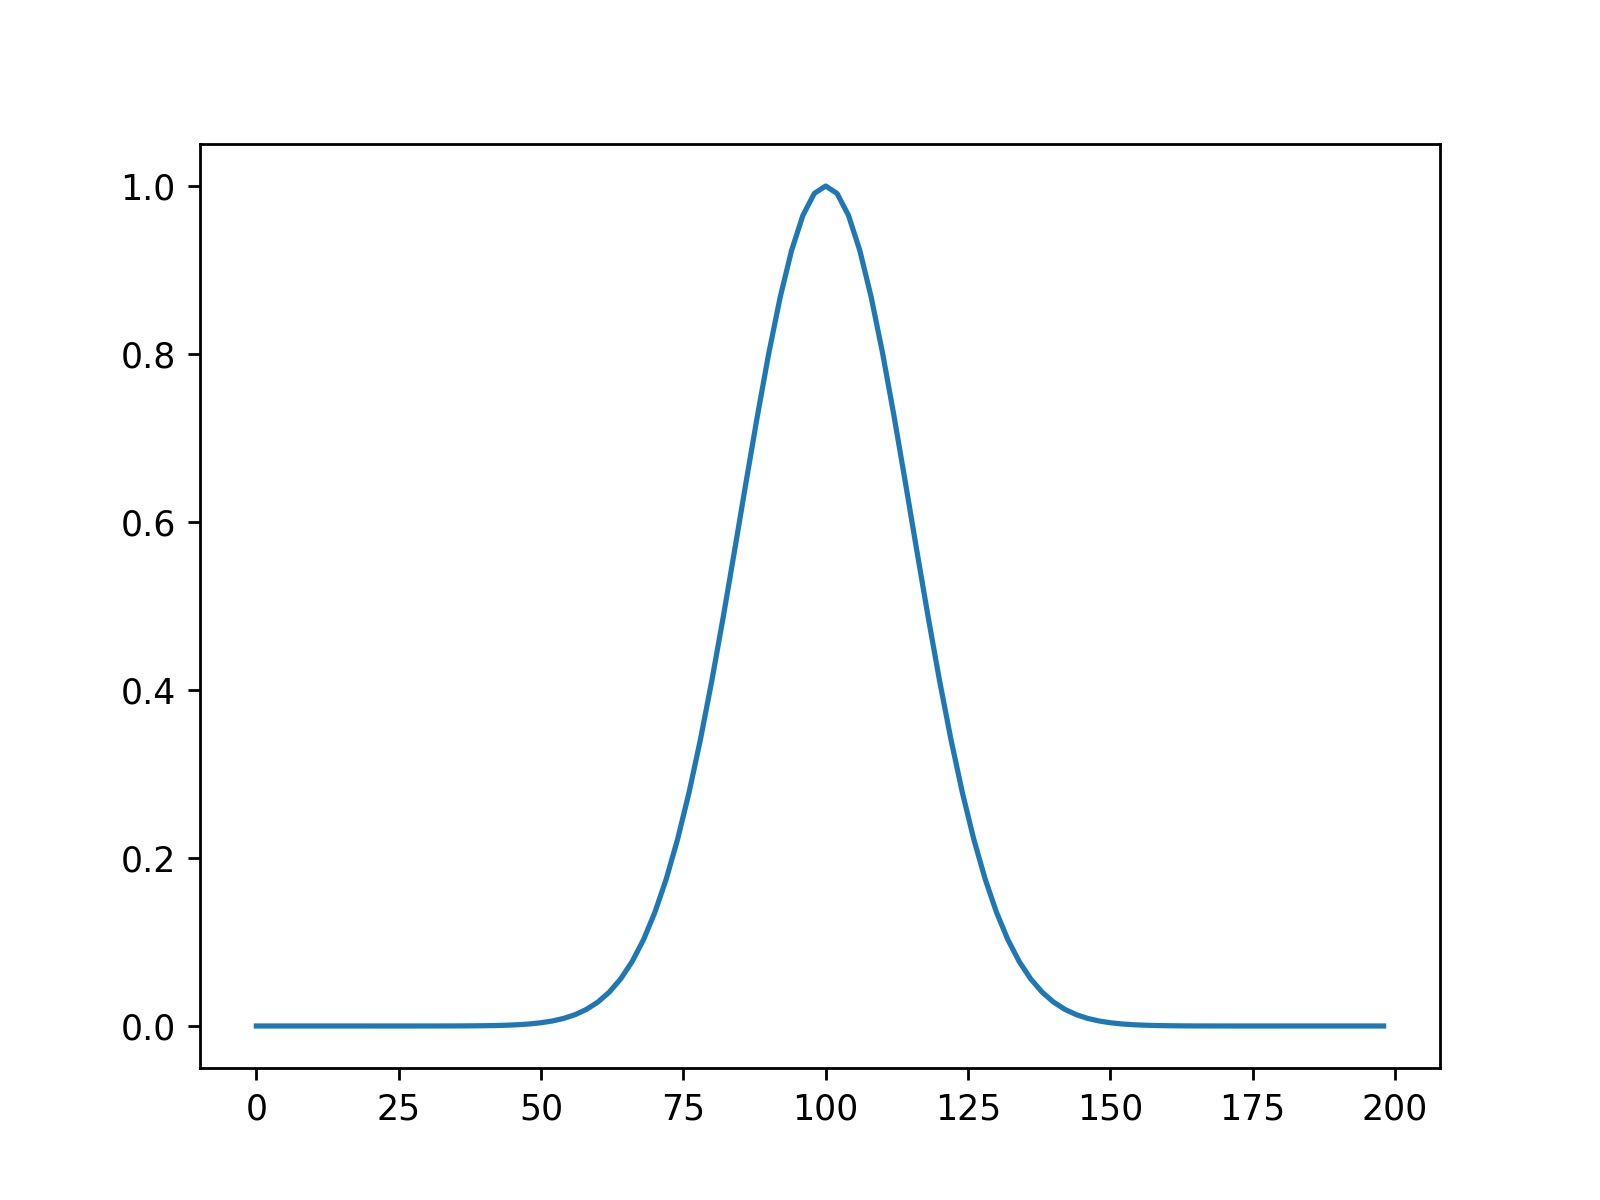

In [9]:
plt.figure()
plt.plot(position, pre_rate(100.))

In [10]:
num_inputs = 200
pre_rate_matrix = np.empty((num_inputs, len(position)))

In [11]:
peak_locs = np.linspace(0., track_length, num_inputs, endpoint=False)

In [12]:
for i, peak_loc in enumerate(peak_locs):
    pre_rate_matrix[i,:] = pre_rate(peak_loc)

In [13]:
pre_rate_matrix.shape

(200, 100)

<IPython.core.display.Javascript object>


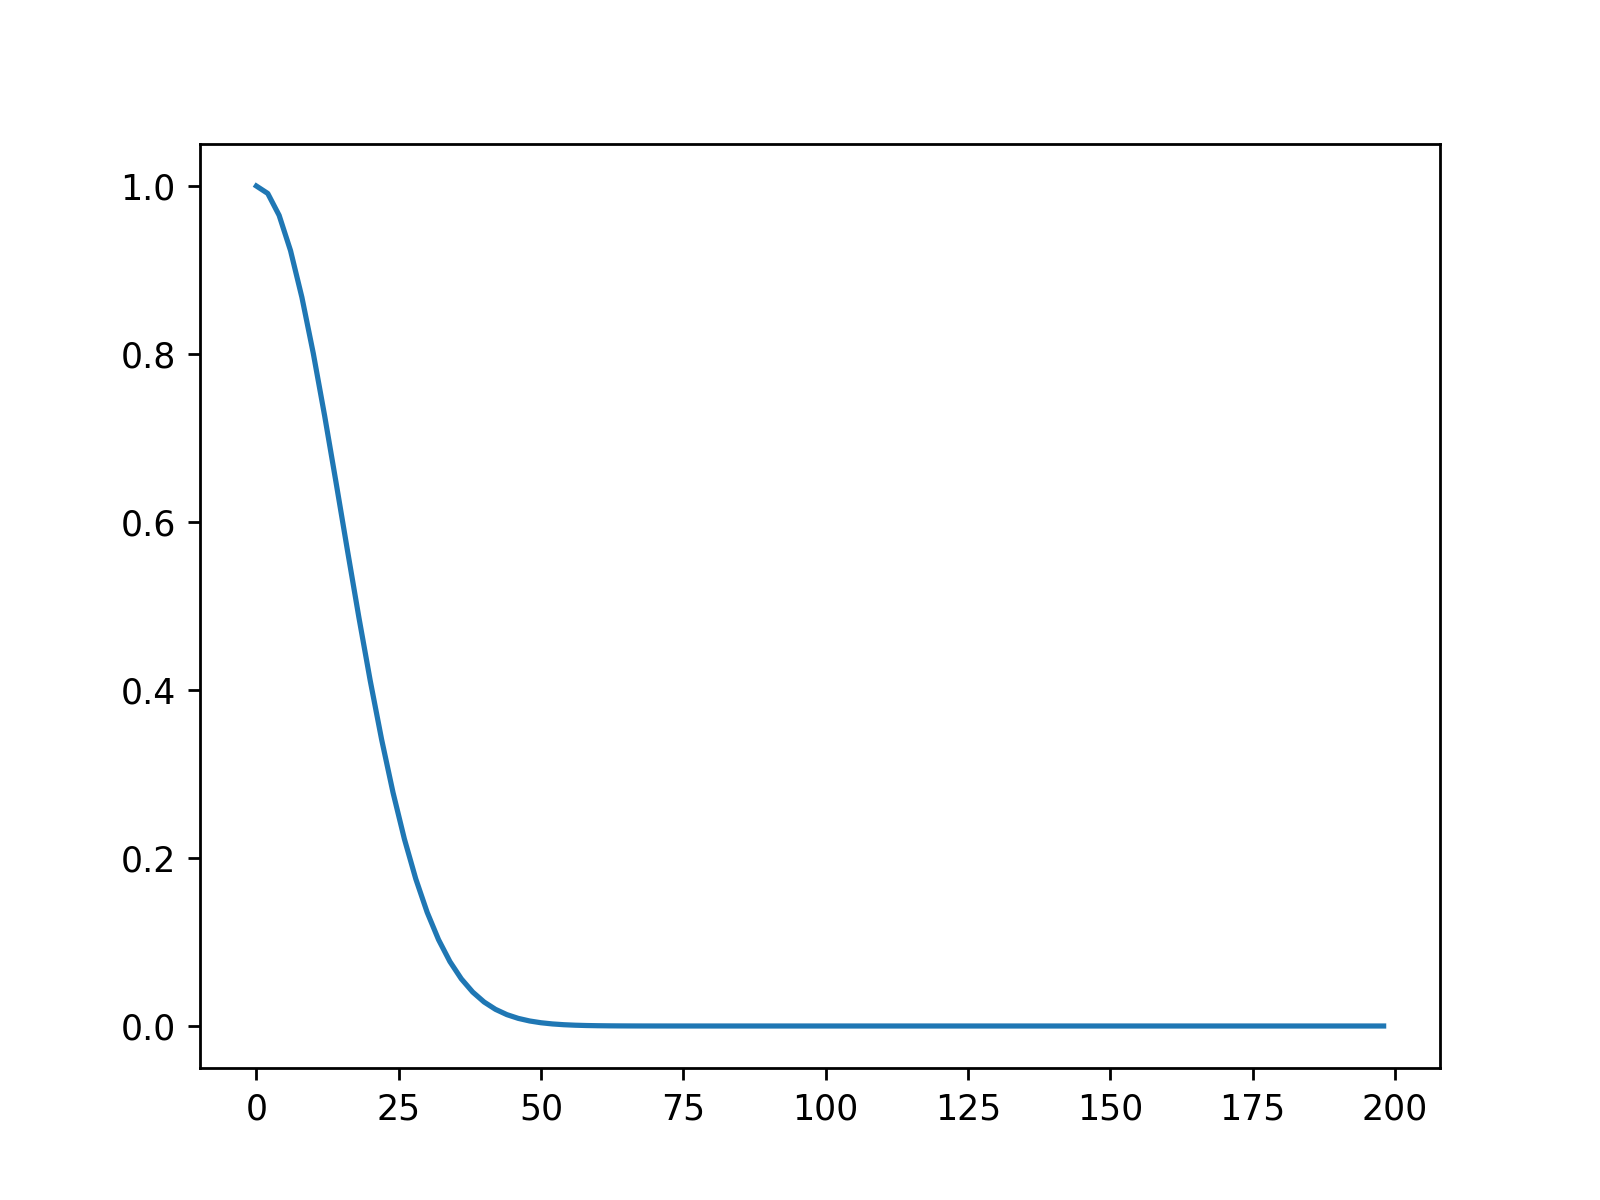

In [14]:
plt.figure()
plt.plot(position, pre_rate_matrix[0,:])

<IPython.core.display.Javascript object>


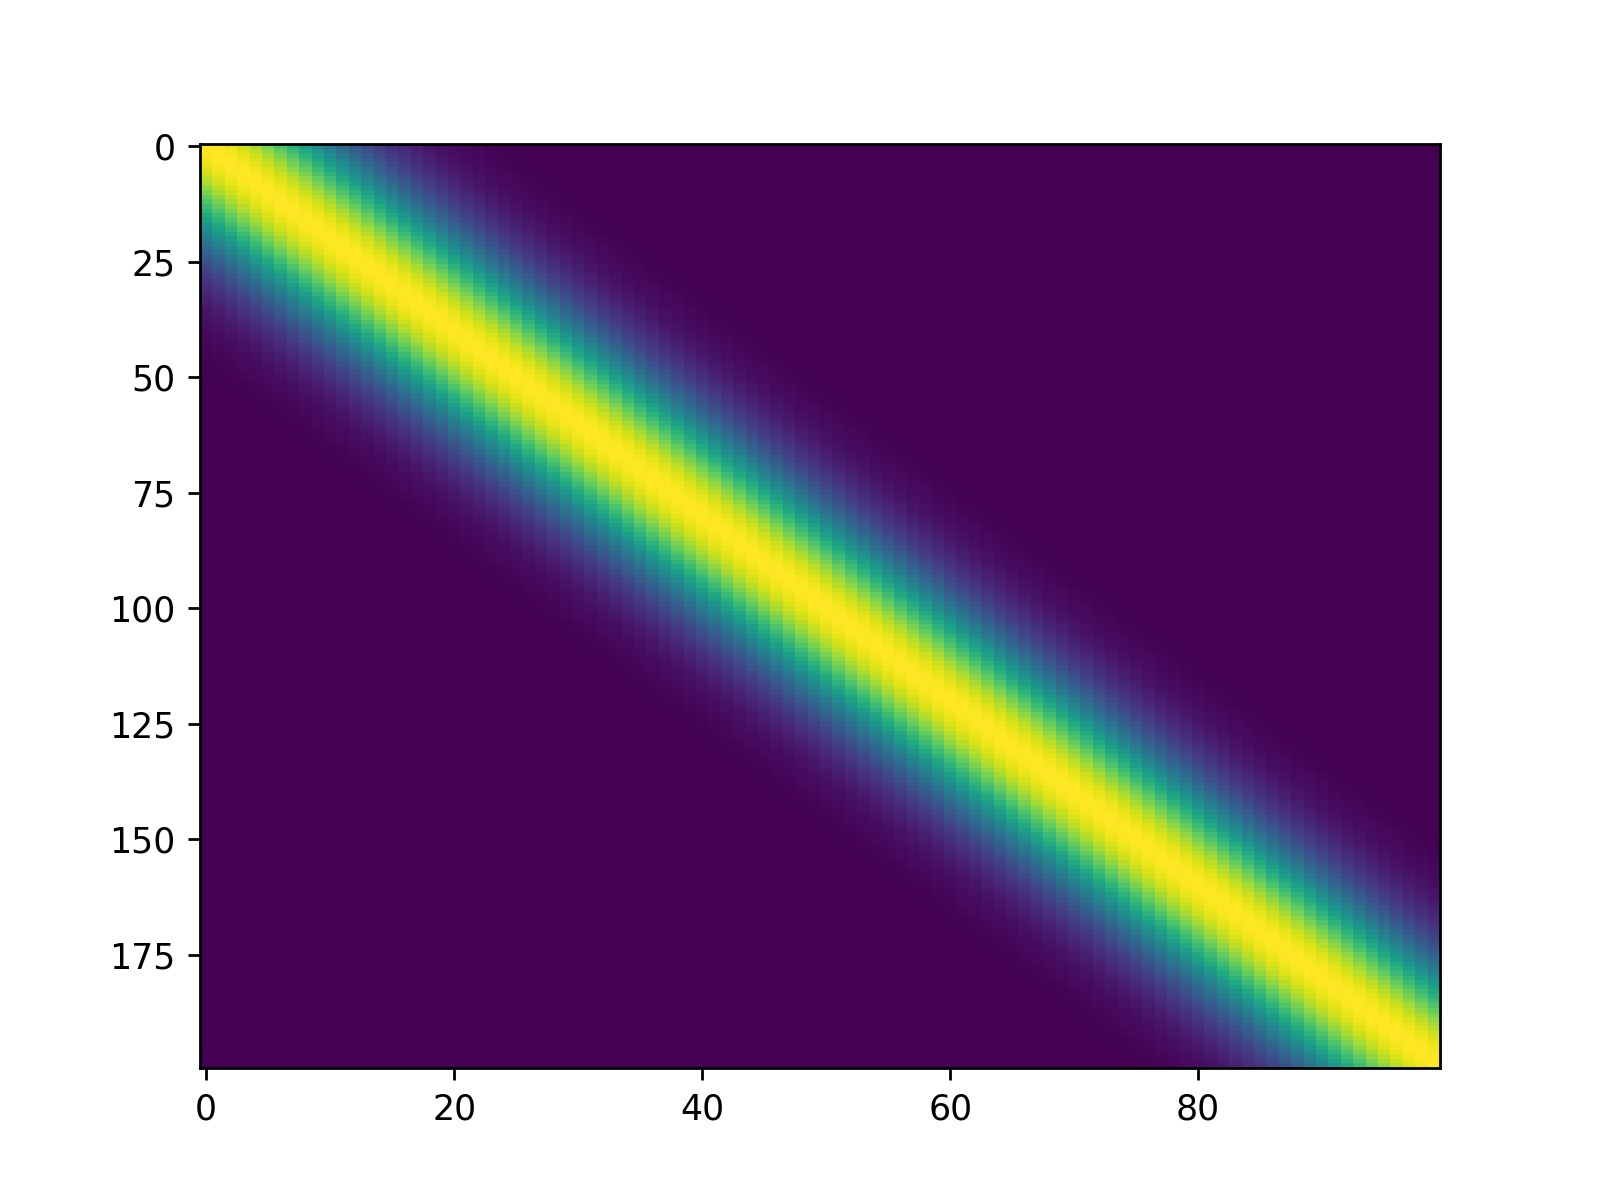

In [16]:
plt.figure()
plt.imshow(pre_rate_matrix, aspect='auto')

In [18]:
extended_position = np.concatenate([position - track_length, position, position + track_length])

In [19]:
def pre_rate_wrap_around(position, peak_loc, field_width, track_length, plot=False):
    extended_position = np.concatenate([position - track_length, position, position + track_length])
    extended_pre_rate = np.exp(-0.5 * ((peak_loc - extended_position)/(field_width / 6.))**2.)
    position_len = len(position)
    chunk1 = np.array(extended_pre_rate[:position_len])
    chunk2 = np.array(extended_pre_rate[position_len:2 * position_len])
    chunk3 = np.array(extended_pre_rate[2 * position_len:])
    pre_rate = np.maximum(chunk1, chunk2)
    pre_rate = np.maximum(pre_rate, chunk3)
    if plot:
        plt.figure()
        plt.plot(position, pre_rate)
        plt.figure()
        plt.plot(extended_position, extended_pre_rate)
    return pre_rate
    

<IPython.core.display.Javascript object>


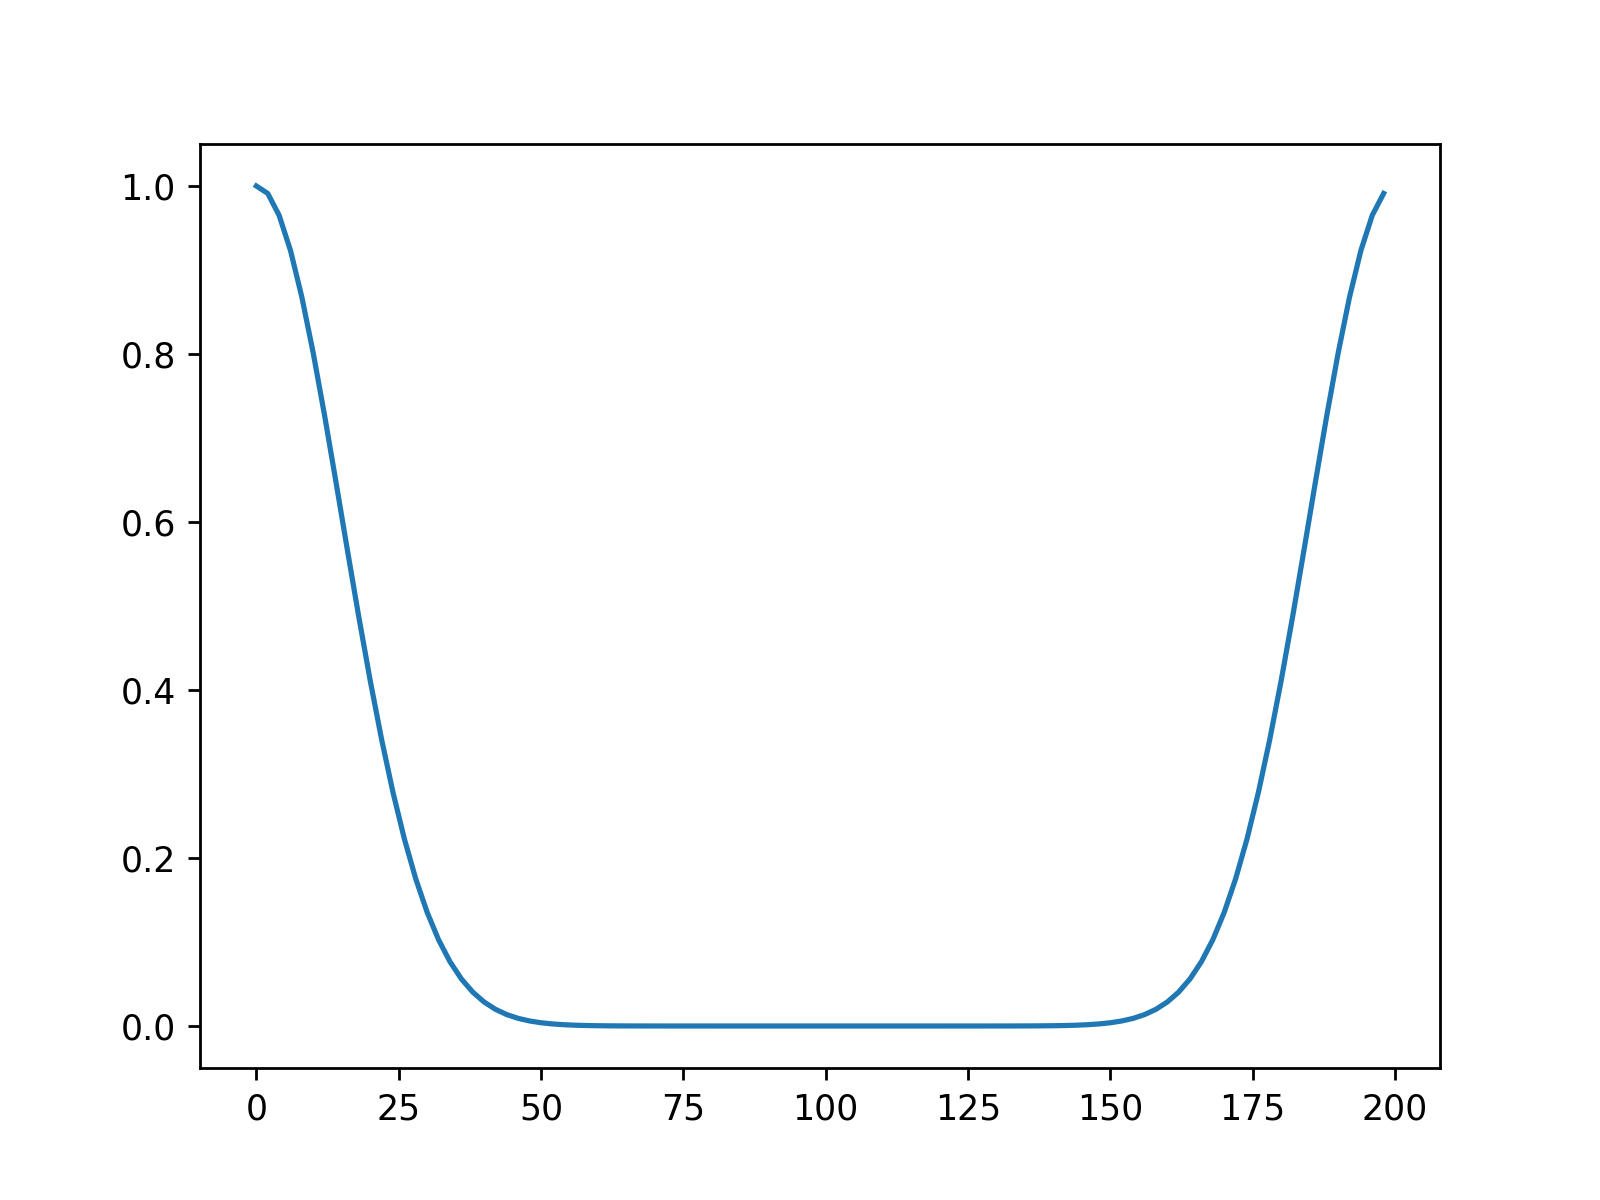

<IPython.core.display.Javascript object>


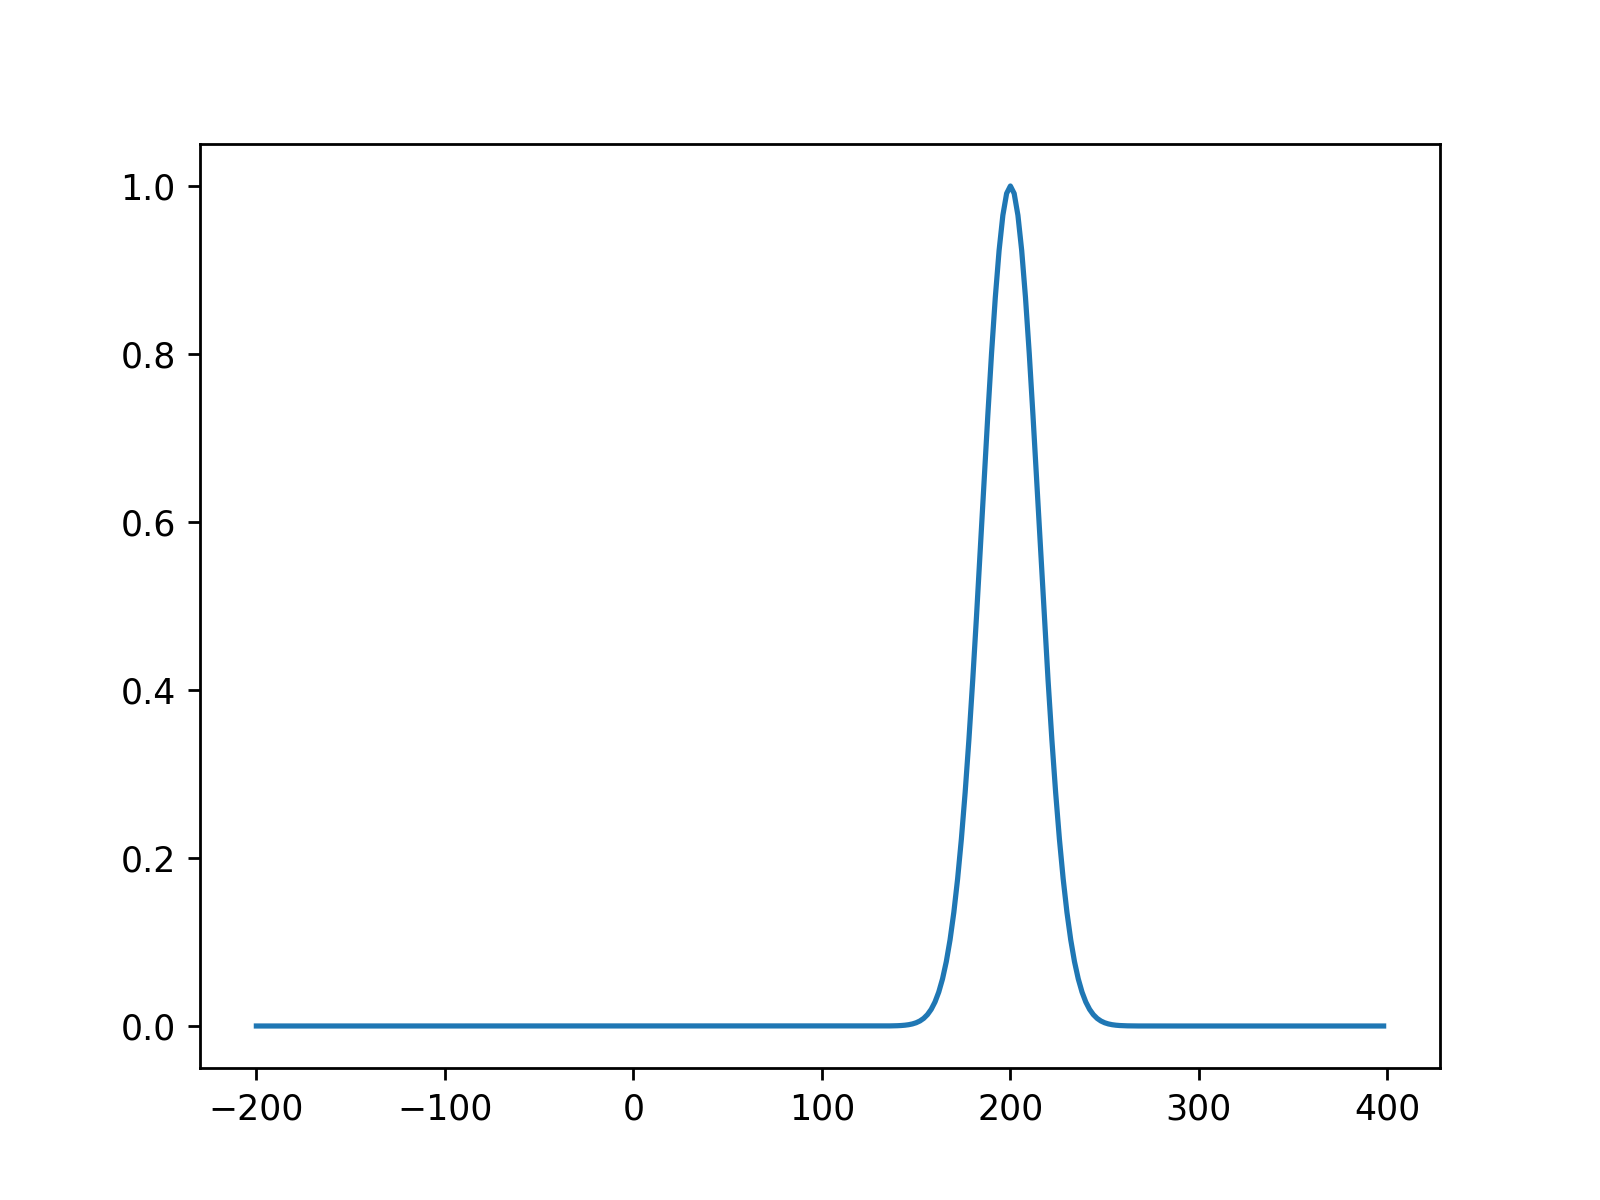

In [20]:
test = pre_rate_wrap_around(position, track_length, field_width, track_length, plot=True)

In [21]:
for i, peak_loc in enumerate(peak_locs):
    pre_rate_matrix[i,:] = pre_rate_wrap_around(position, peak_loc, field_width, track_length)

<IPython.core.display.Javascript object>


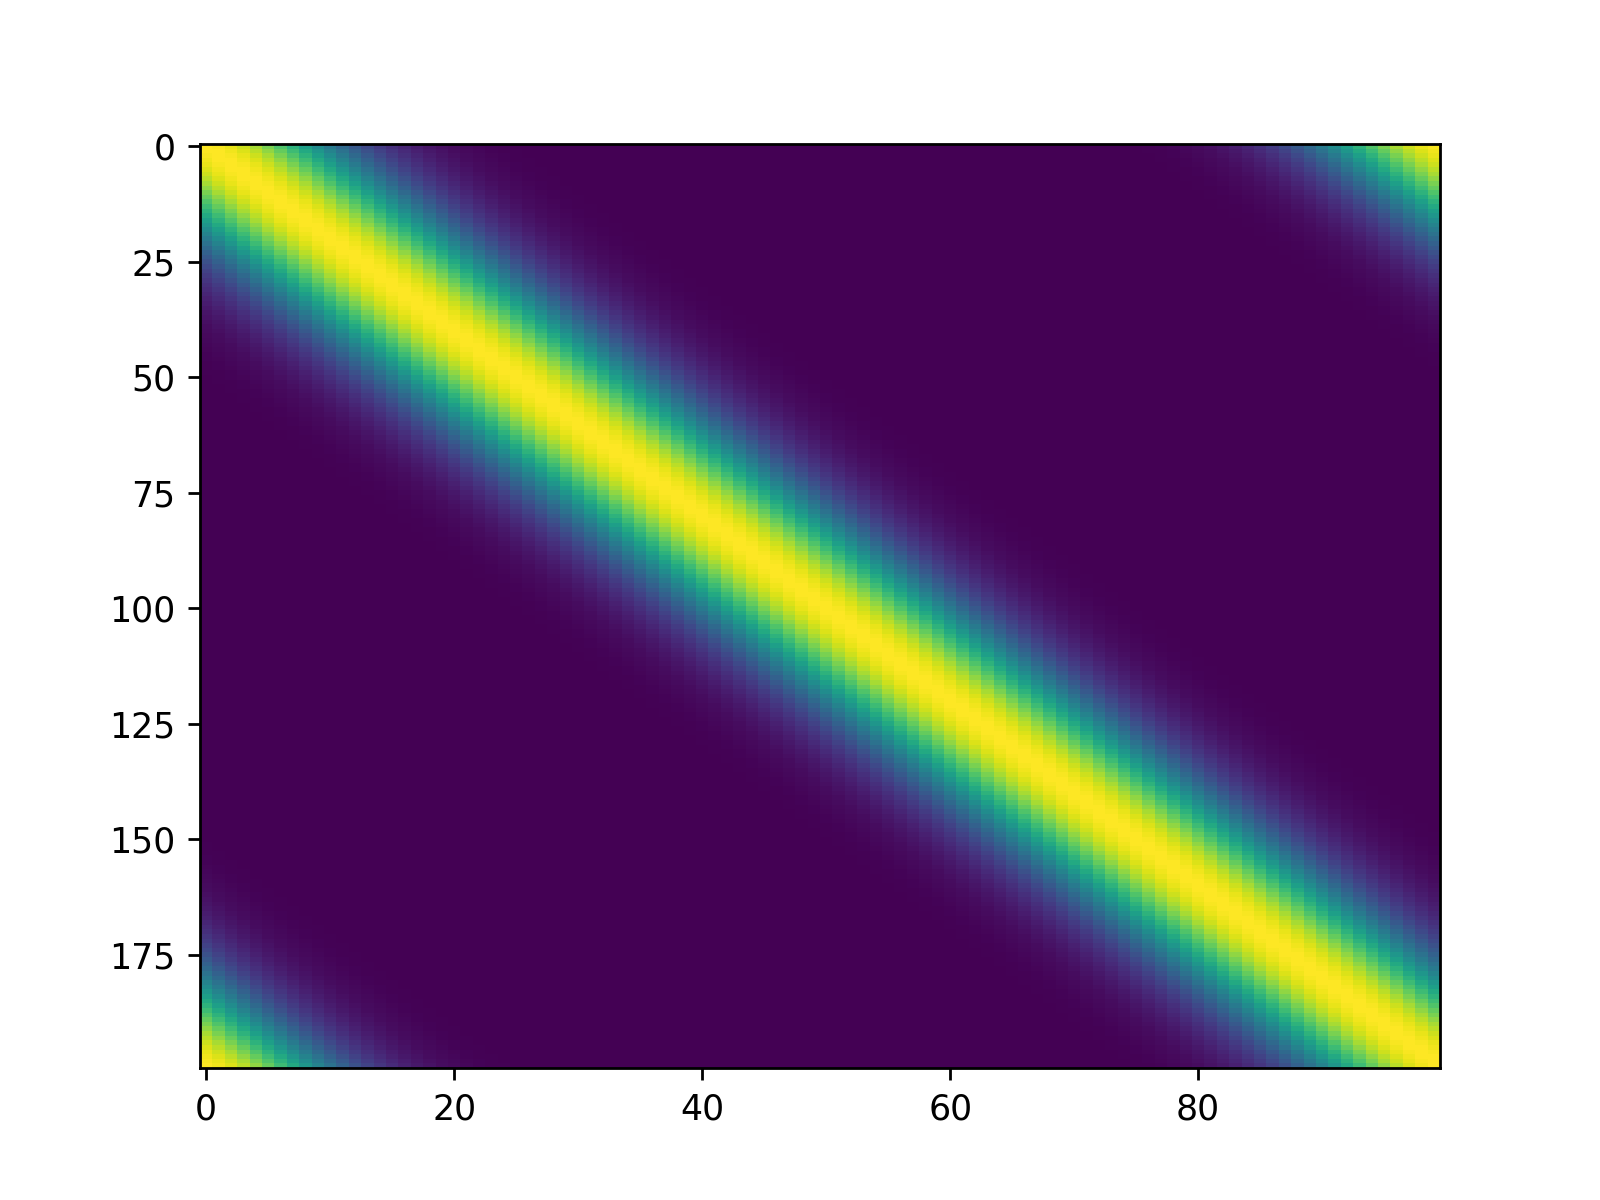

In [22]:
plt.figure()
plt.imshow(pre_rate_matrix, aspect='auto')

In [23]:
duration = track_length / run_vel
extended_t = np.concatenate([t - duration, t, t + duration])

In [24]:
pre_rate_in_time_matrix = np.empty((num_inputs, len(extended_t)))

In [25]:
for i, pre_rate in enumerate(pre_rate_matrix):
    pre_rate_in_time_matrix[i,:] = np.concatenate([pre_rate] * 3)

<IPython.core.display.Javascript object>


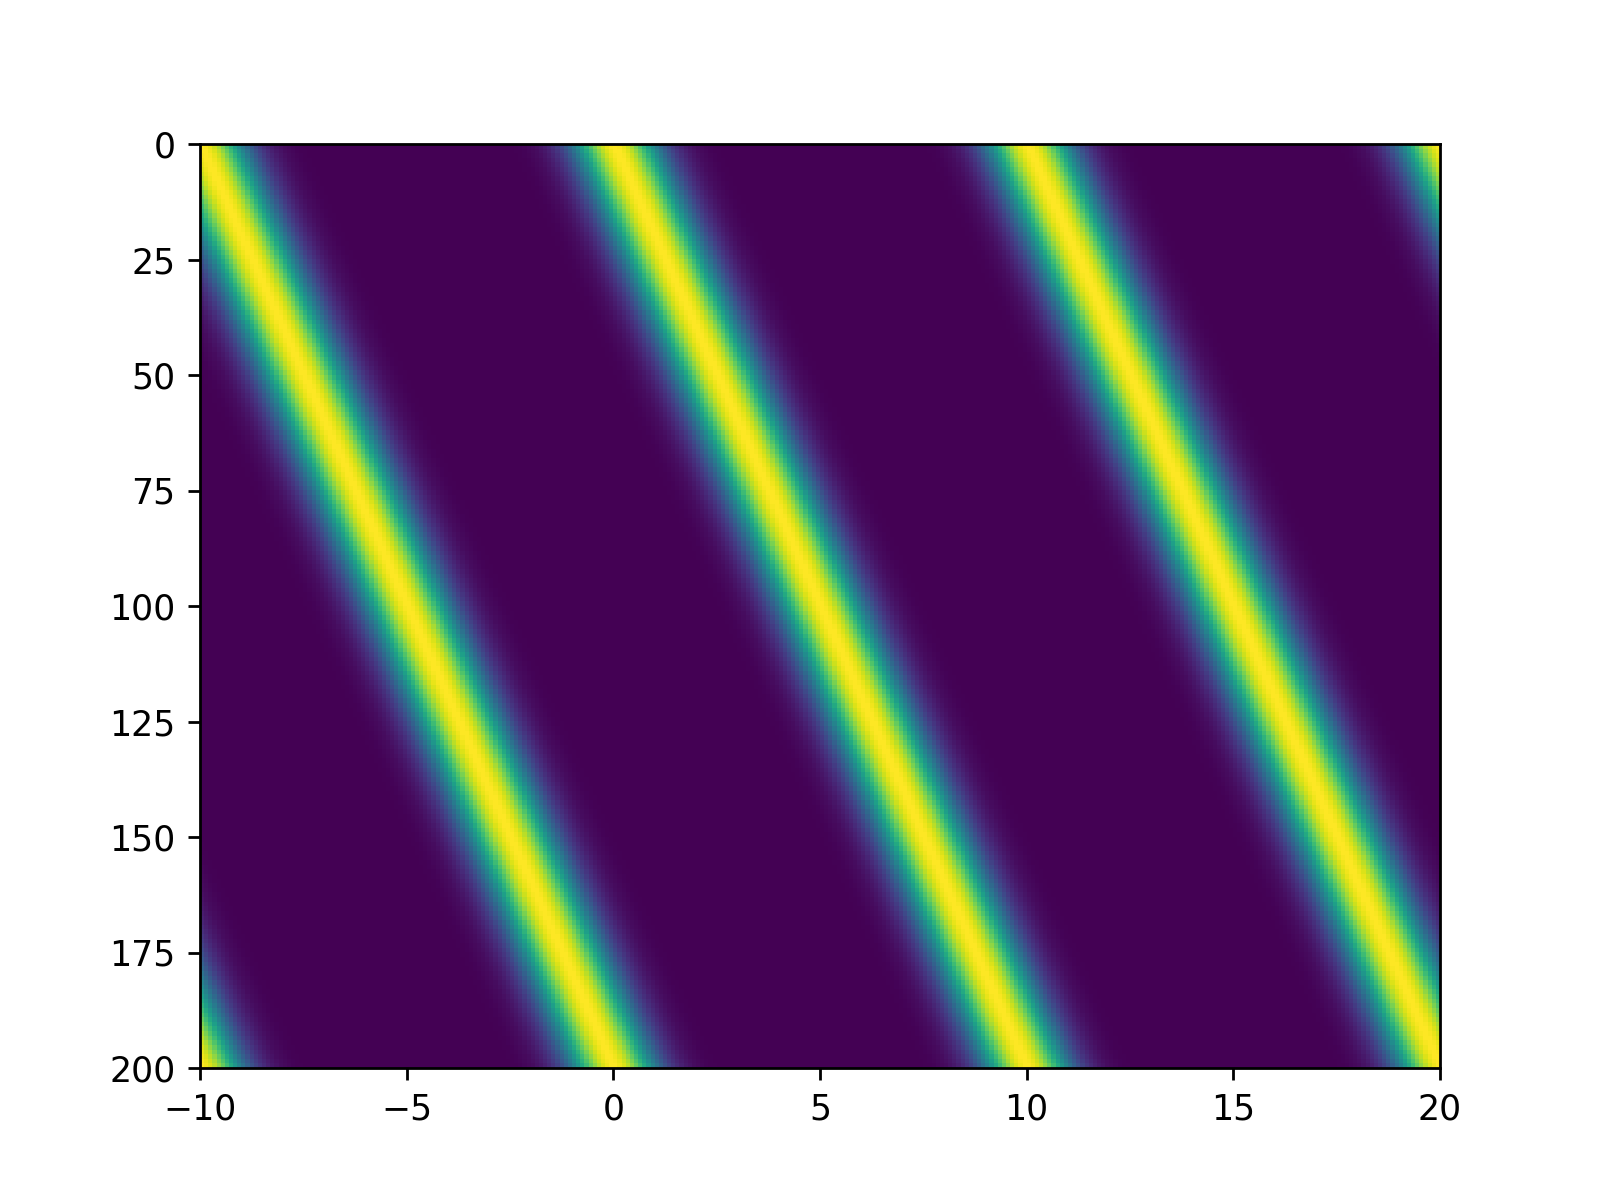

In [28]:
plt.figure()
plt.imshow(pre_rate_in_time_matrix, aspect='auto', extent=[-duration, 2. * duration, num_inputs, 0])

In [29]:
weights = np.ones(num_inputs)

In [30]:
ramp = weights.dot(pre_rate_in_time_matrix)

<IPython.core.display.Javascript object>


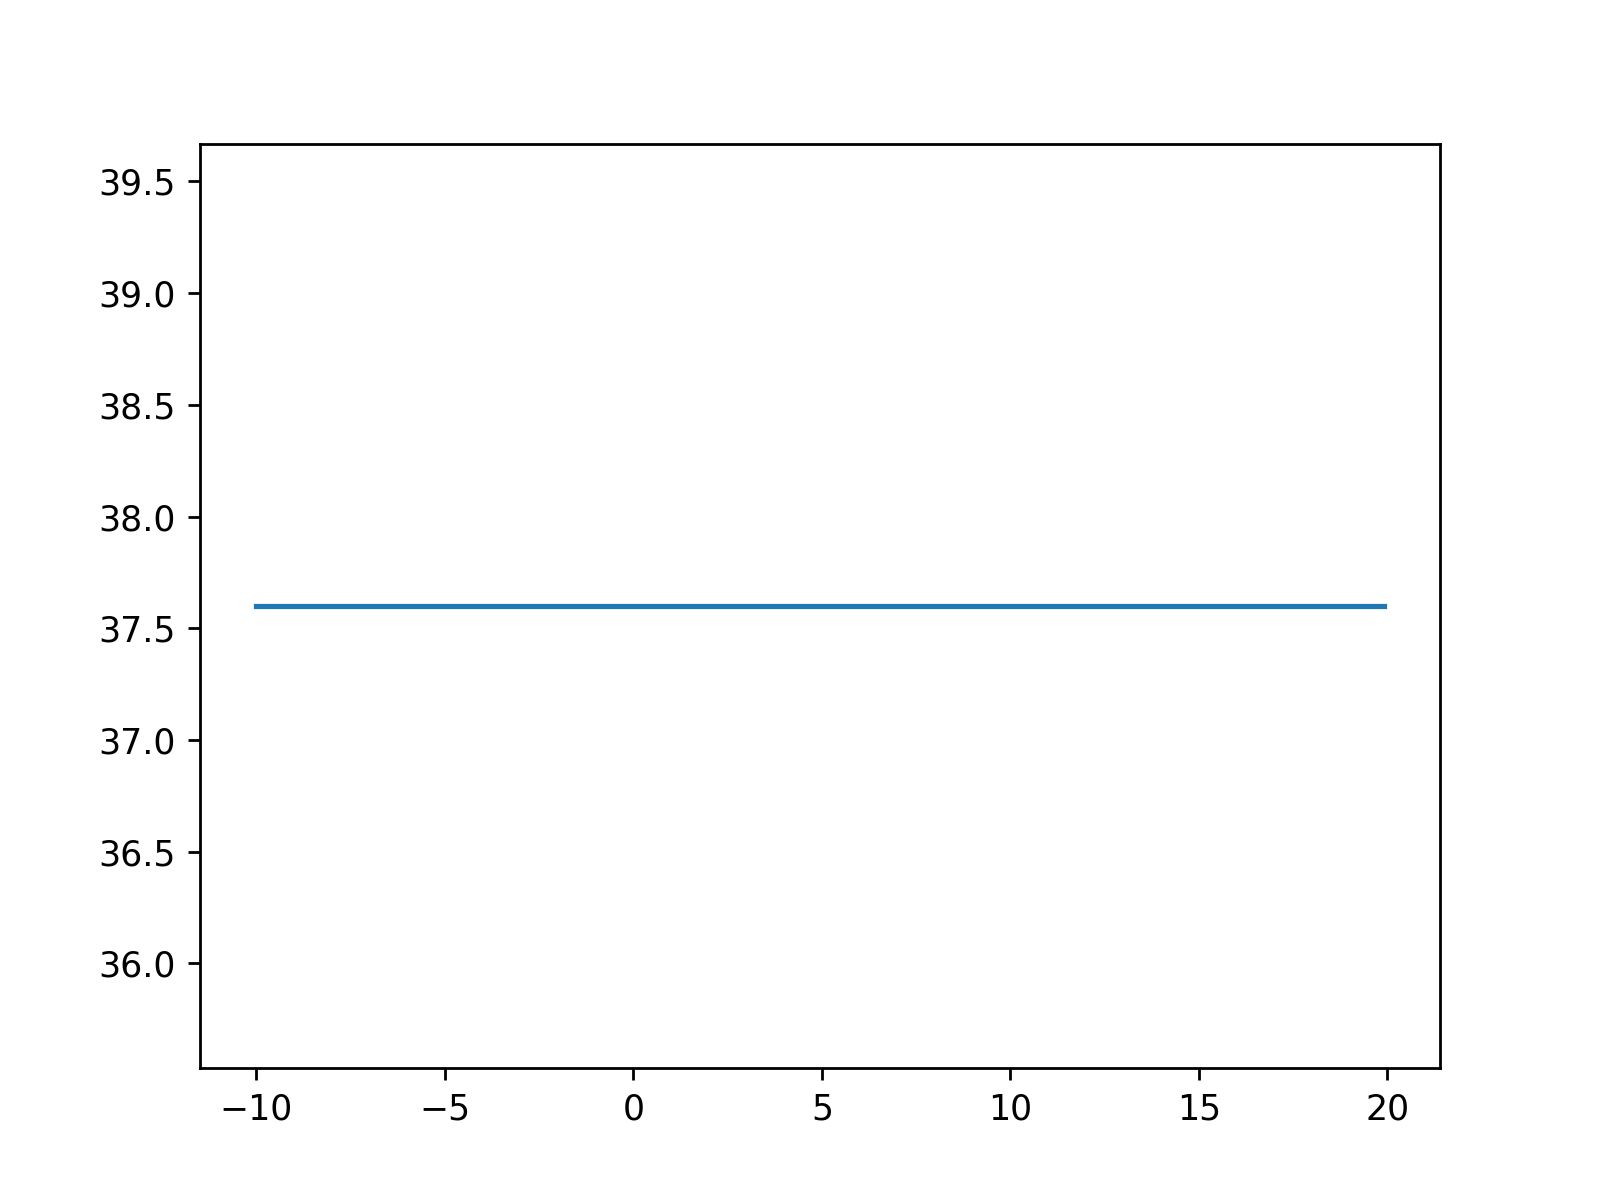

In [31]:
plt.figure()
plt.plot(extended_t, ramp)

In [32]:
silent_weights = np.array(weights)

In [33]:
get_place_cell_weights = lambda peak_loc, field_width, peak_locs, background_weight, peak_weight: background_weight + (peak_weight - background_weight) * np.exp(-0.5 * ((peak_loc - peak_locs)/(field_width / 6.))**2.)

In [34]:
place1_weights = get_place_cell_weights(track_length / 2., 1.2 * field_width, peak_locs, 1., 2.5)

<IPython.core.display.Javascript object>


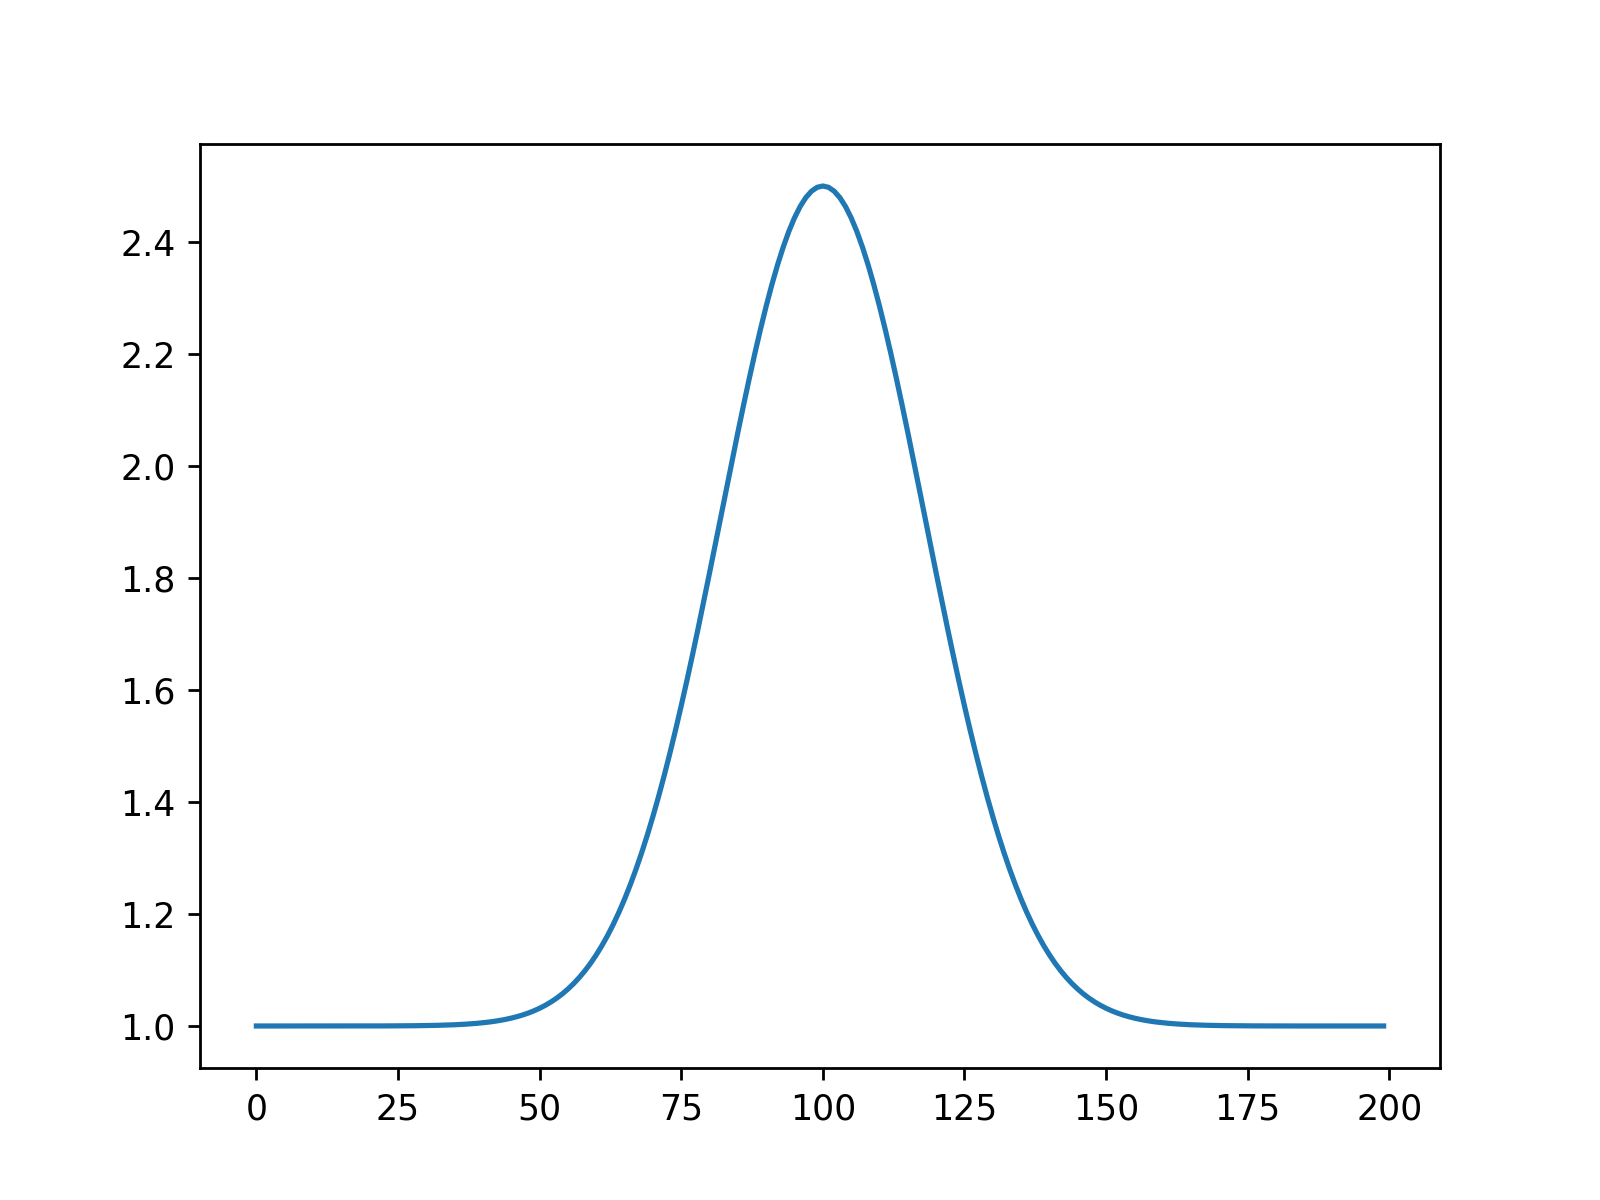

In [116]:
plt.figure()
plt.plot(peak_locs, place1_weights)

In [38]:
silent_ramp = ramp_scaling_factor * silent_weights.dot(pre_rate_matrix)
place1_ramp = ramp_scaling_factor * place1_weights.dot(pre_rate_matrix)

Vm_background = np.mean(silent_ramp)

<IPython.core.display.Javascript object>


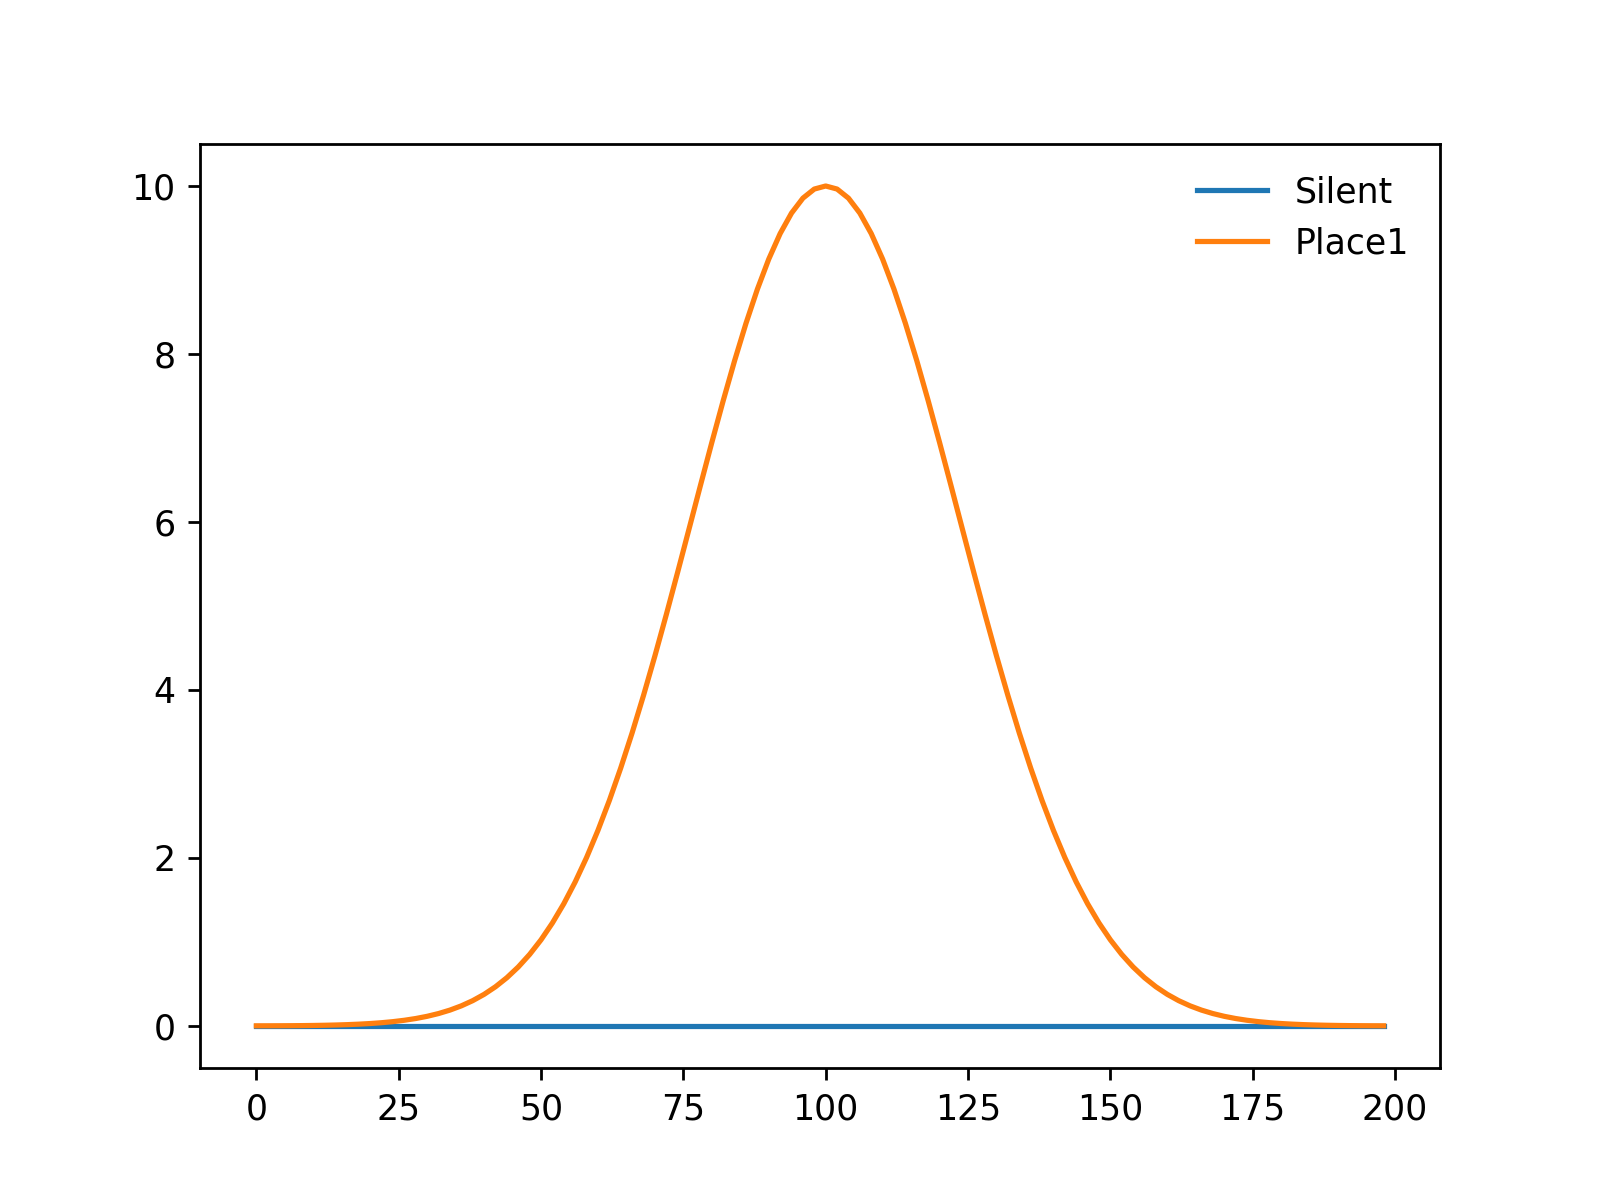

In [39]:
plt.figure()
plt.plot(position, silent_ramp - Vm_background, label='Silent')
plt.plot(position, place1_ramp - Vm_background, label='Place1')
plt.legend(loc='best', frameon=False)

In [120]:
# ramp_scaling_factor = 10. / np.max(place1_ramp - silent_ramp)

In [121]:
# ramp_scaling_factor = 0.2308028752748705

0.2308028752748705

In [51]:
t[1] - t[0]

0.01

In [52]:
duration

10.0

In [53]:
original_t = np.array(t)
original_extended_t = np.array(extended_t)

In [54]:
t = np.arange(0., duration, 0.01)

In [55]:
t[-1]

9.99

In [56]:
extended_t = np.concatenate([t - duration, t, t + duration])

In [57]:
original_pre_rate_in_time_matrix = np.array(pre_rate_in_time_matrix)

In [58]:
pre_rate_in_time_matrix = np.empty((num_inputs, len(extended_t)))

In [59]:
for i, pre_rate_in_time in enumerate(original_pre_rate_in_time_matrix):
    pre_rate_in_time_matrix[i,:] = np.interp(extended_t, original_extended_t, pre_rate_in_time)

<IPython.core.display.Javascript object>


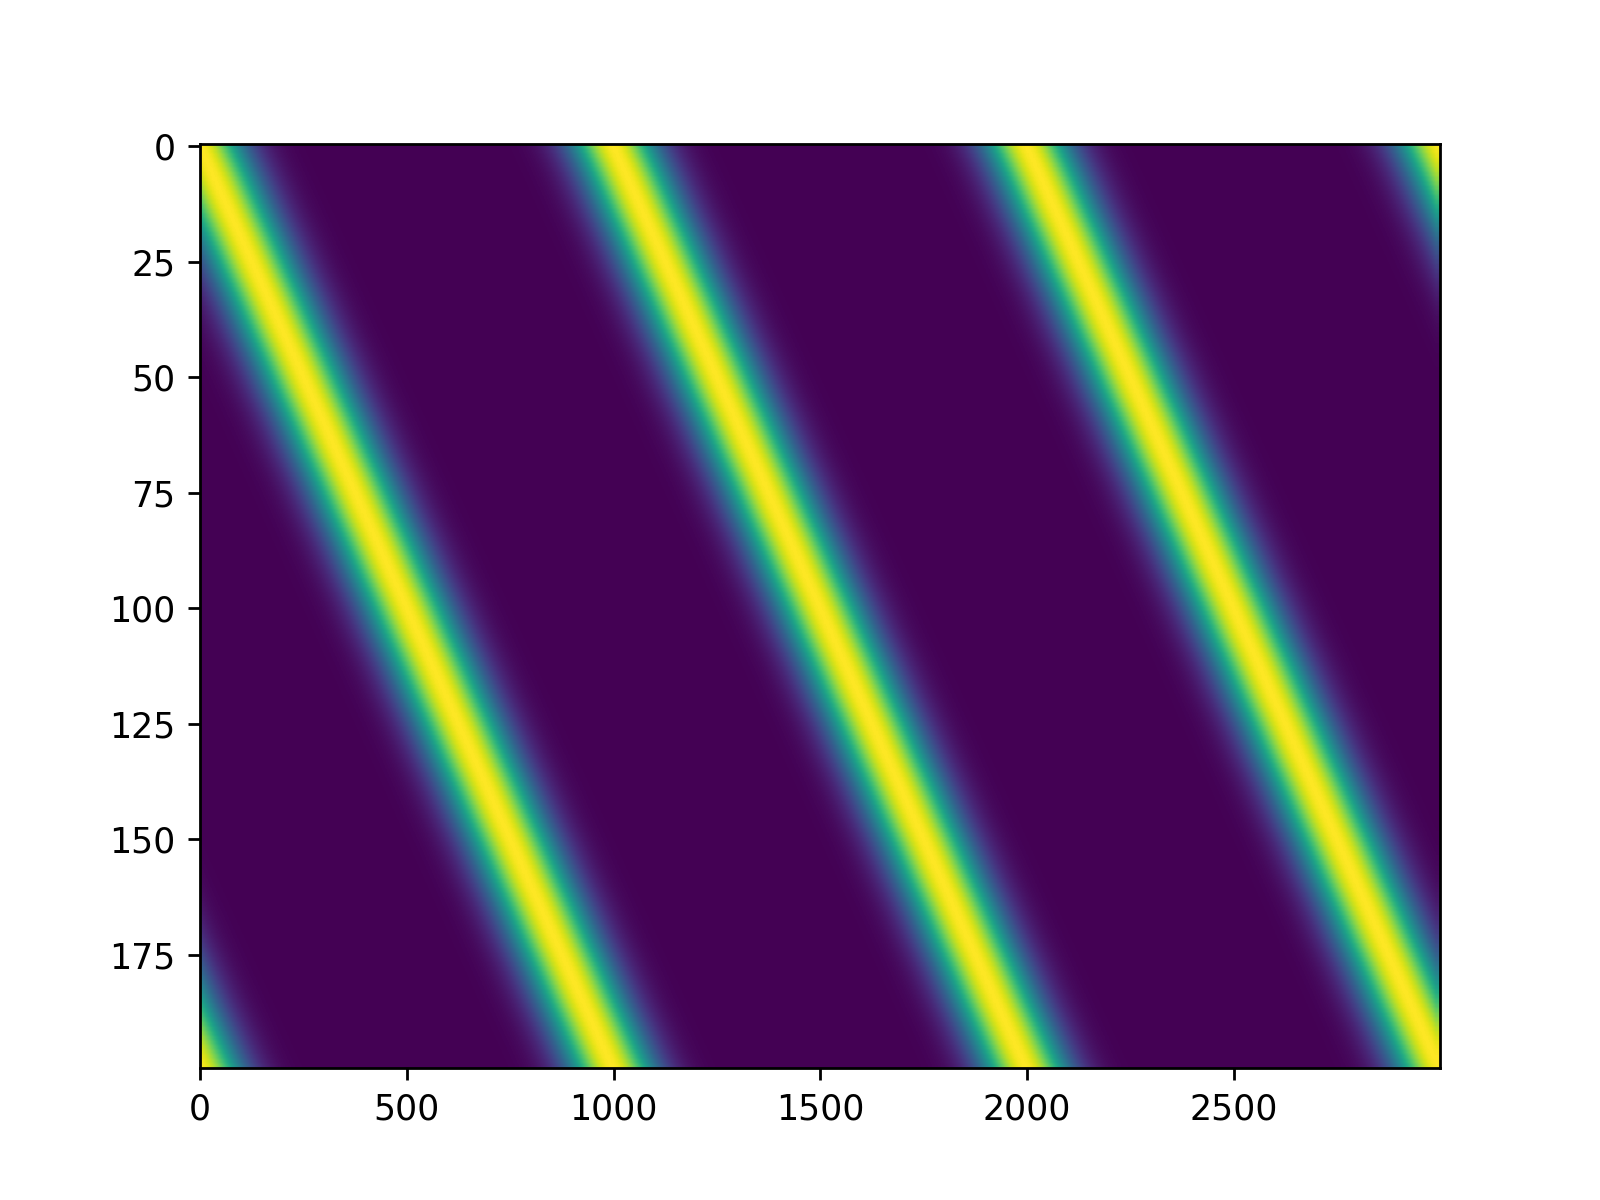

In [60]:
plt.figure()
plt.imshow(pre_rate_in_time_matrix, aspect='auto')

In [61]:
tau_E = 1.  # s

In [62]:
dt = t[1] - t[0]

In [63]:
dt

0.01

In [64]:
E_filter_t = np.arange(0., 6. * tau_E, dt)

In [65]:
E_filter = np.exp(-E_filter_t/tau_E)
E_filter /= np.sum(E_filter)

<IPython.core.display.Javascript object>


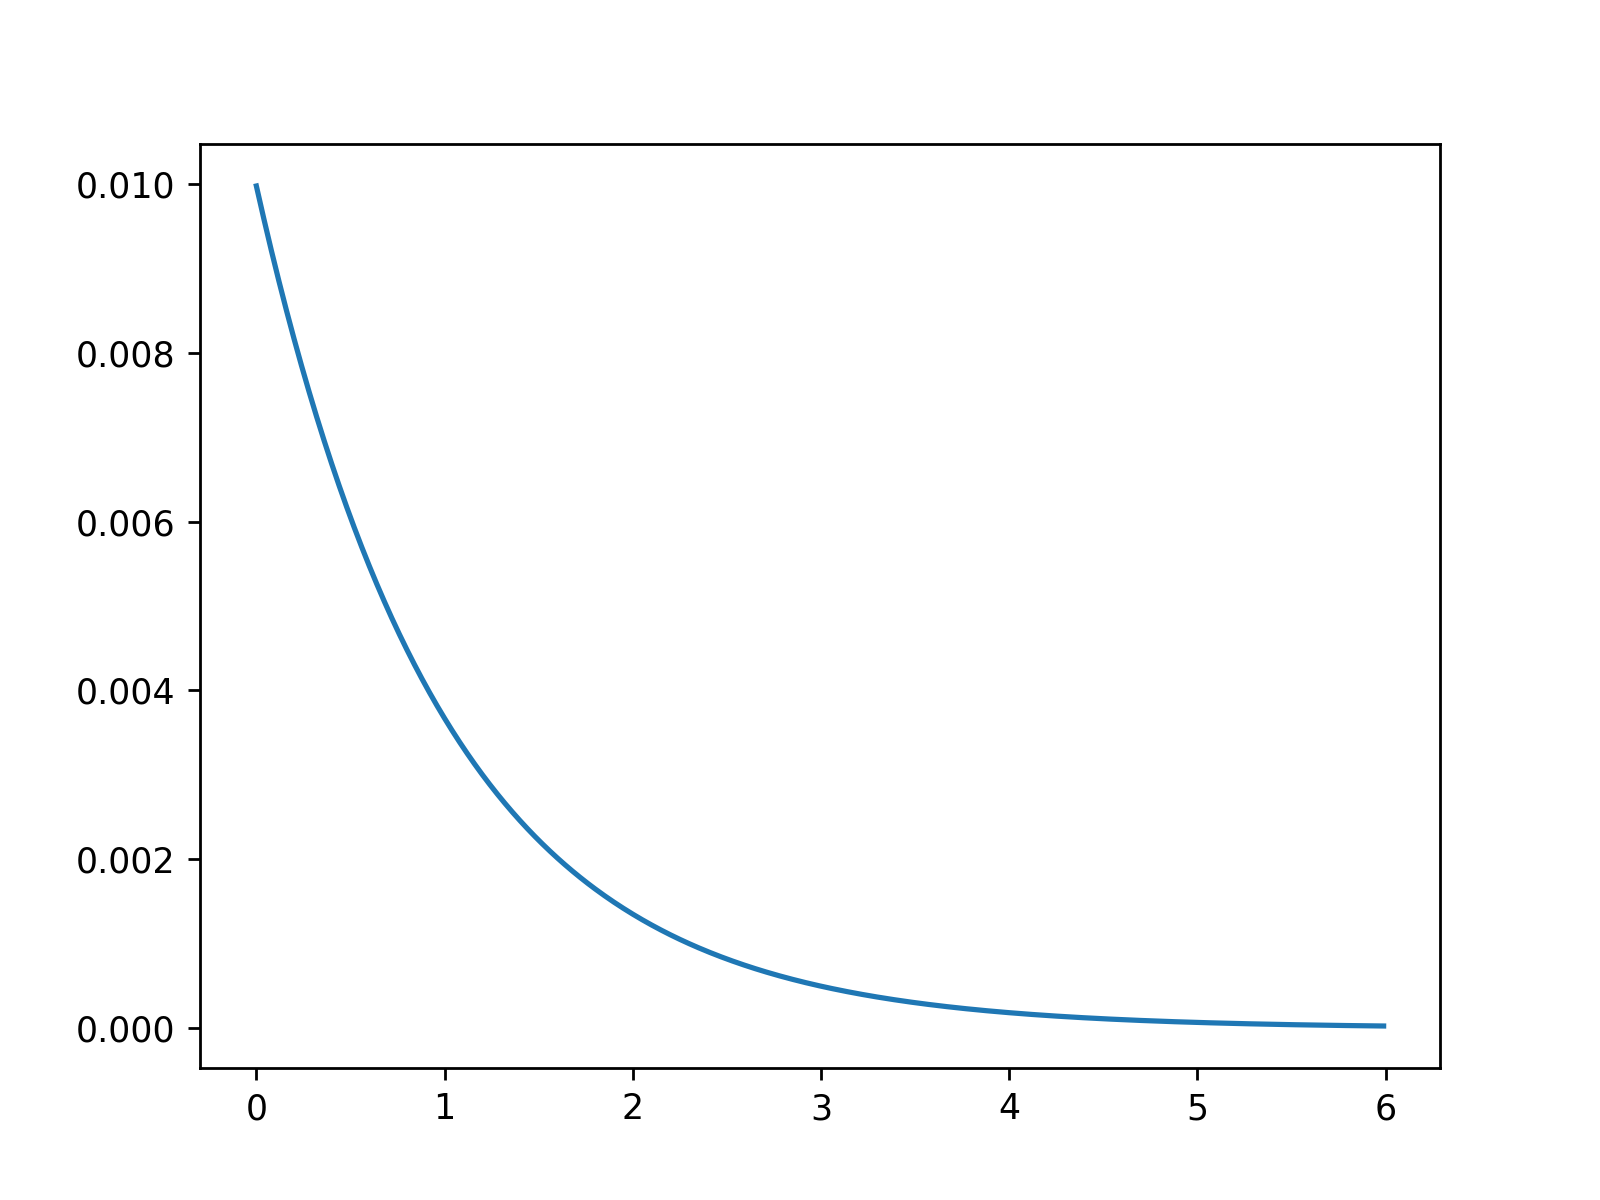

In [66]:
plt.figure()
plt.plot(E_filter_t, E_filter)

In [67]:
test = pre_rate_in_time_matrix[0,:]

In [68]:
example_E_trace = np.convolve(test, E_filter, mode='full')[:len(test)]

<IPython.core.display.Javascript object>


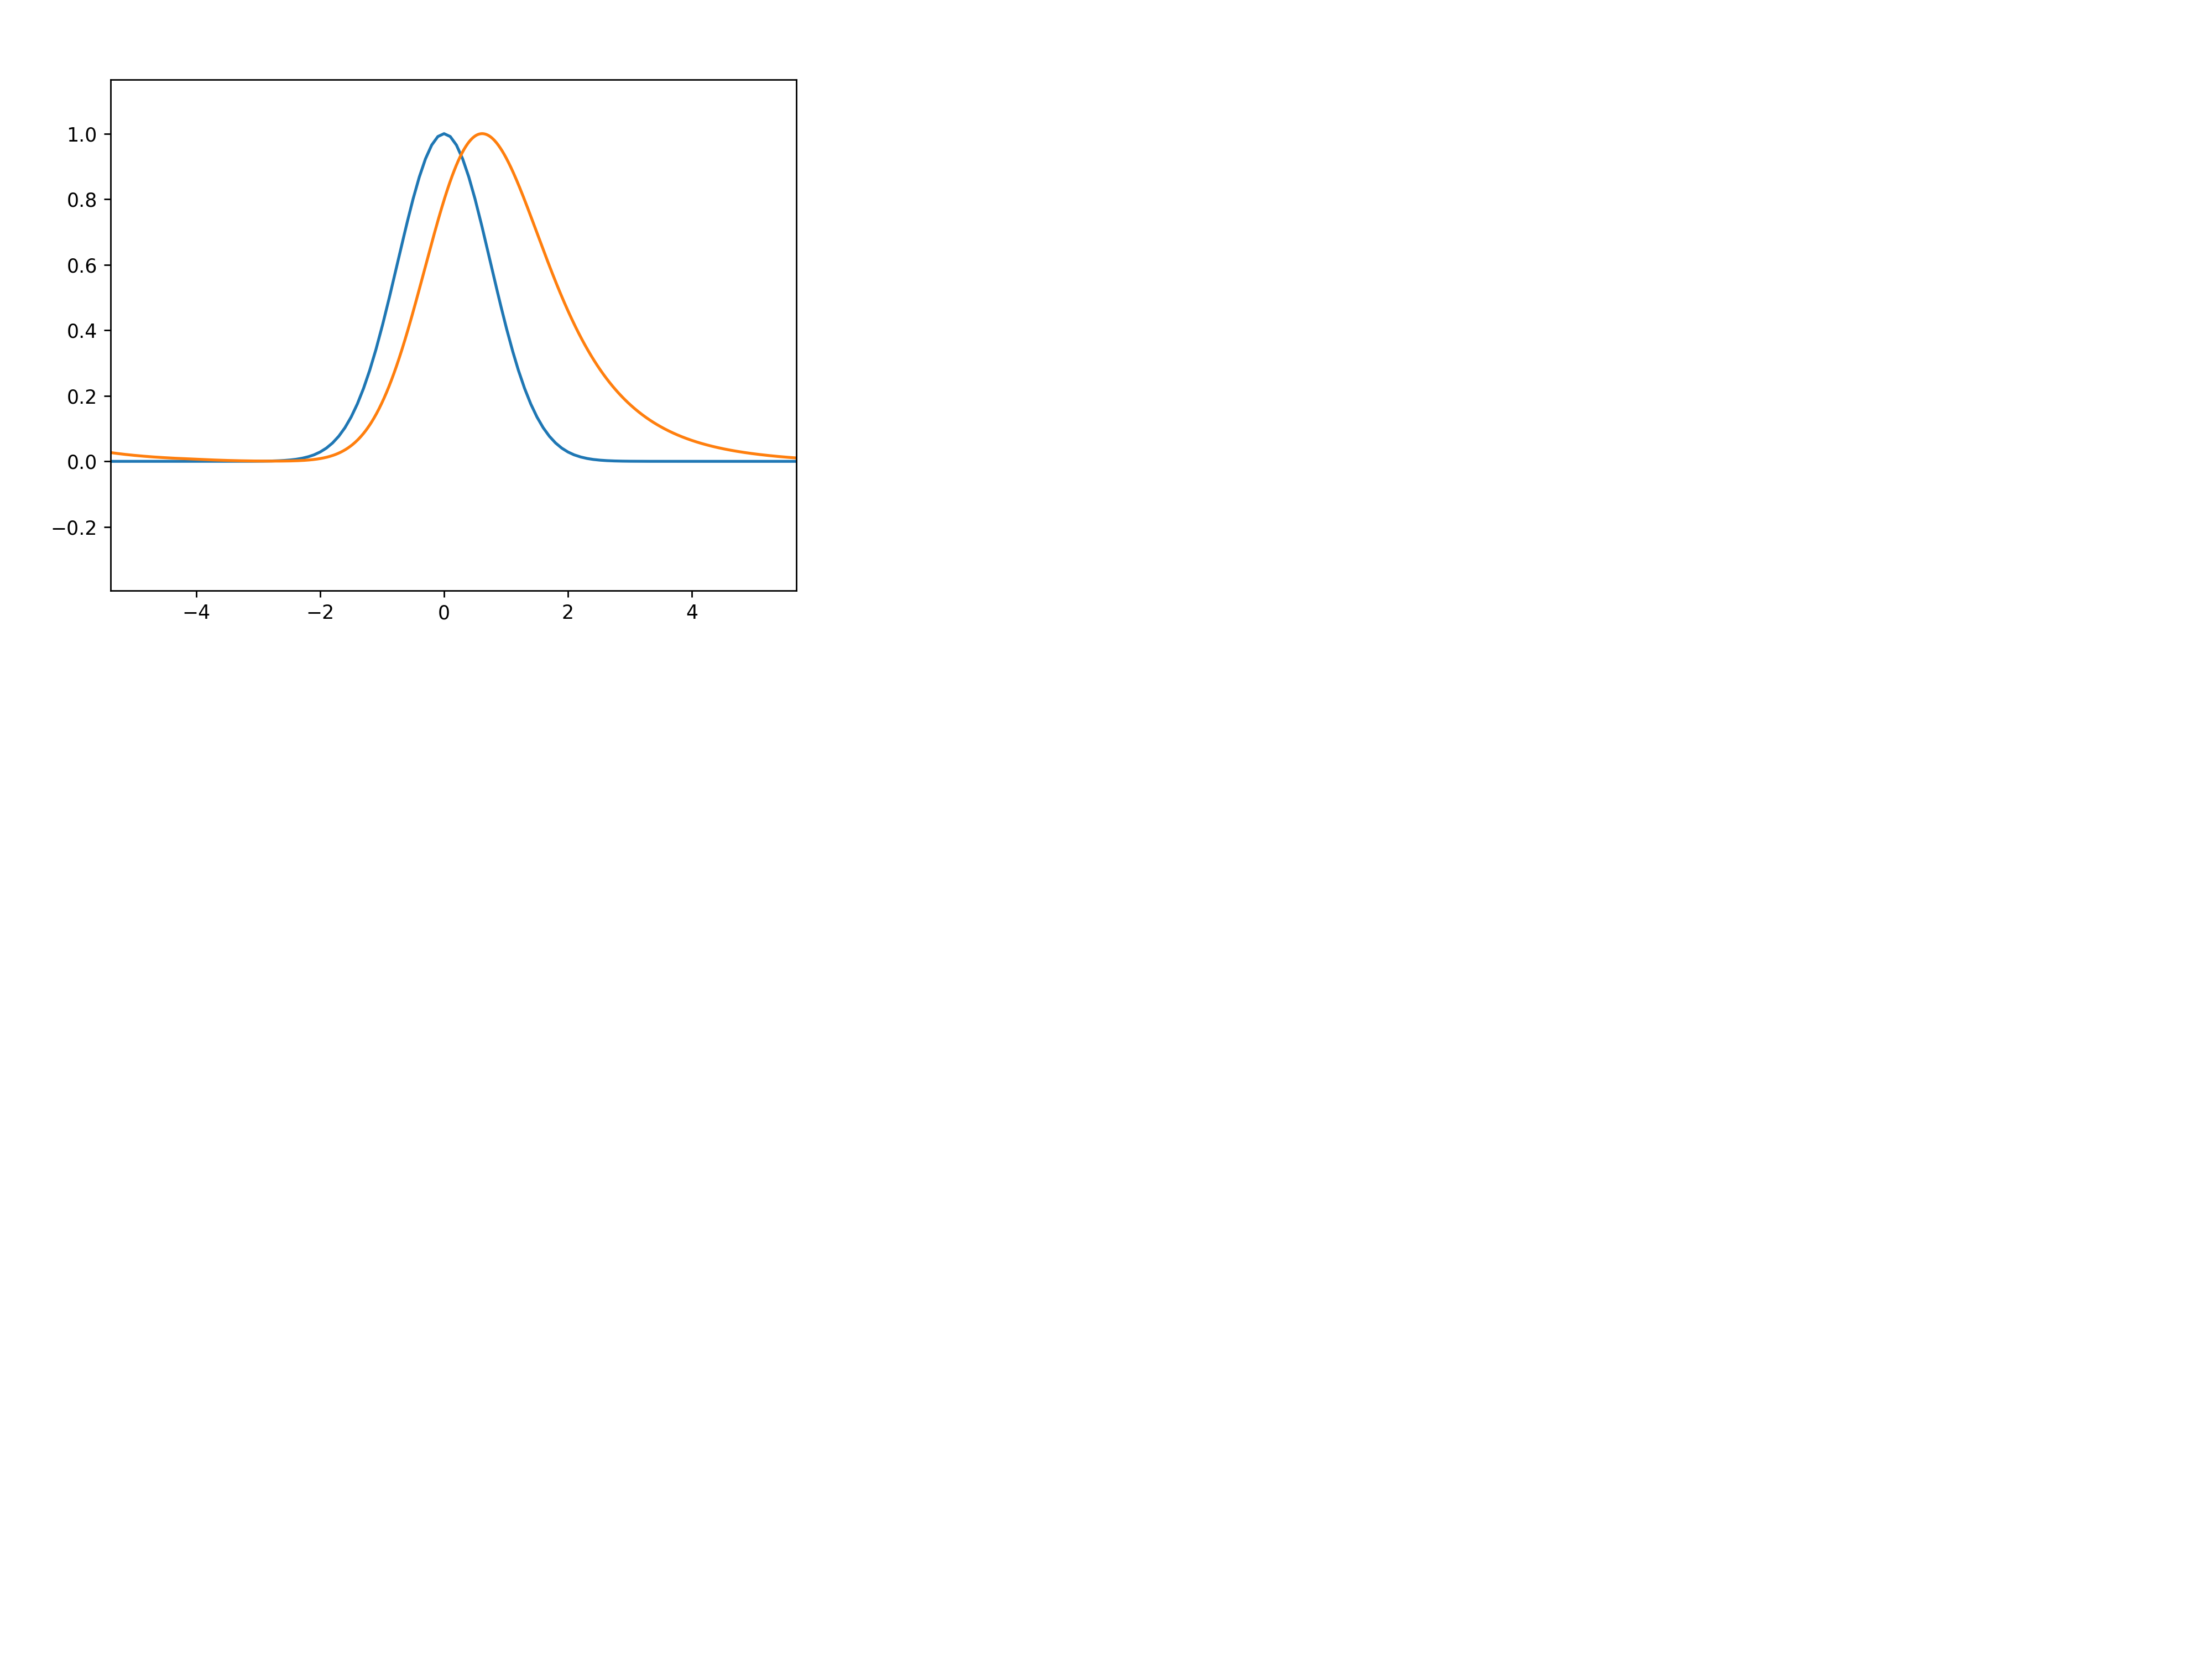

In [69]:
plt.figure()
plt.plot(extended_t, test / np.max(test))
plt.plot(extended_t, example_E_trace / np.max(example_E_trace))

In [70]:
plateau_duration = 0.3  # seconds
plateau_loc = track_length / 2.

In [71]:
plateau_start_index = np.where(extended_position >= plateau_loc)[0][0]

In [72]:
plateau_start_index

150

In [84]:
original_extended_t = extended_position / run_vel

<IPython.core.display.Javascript object>


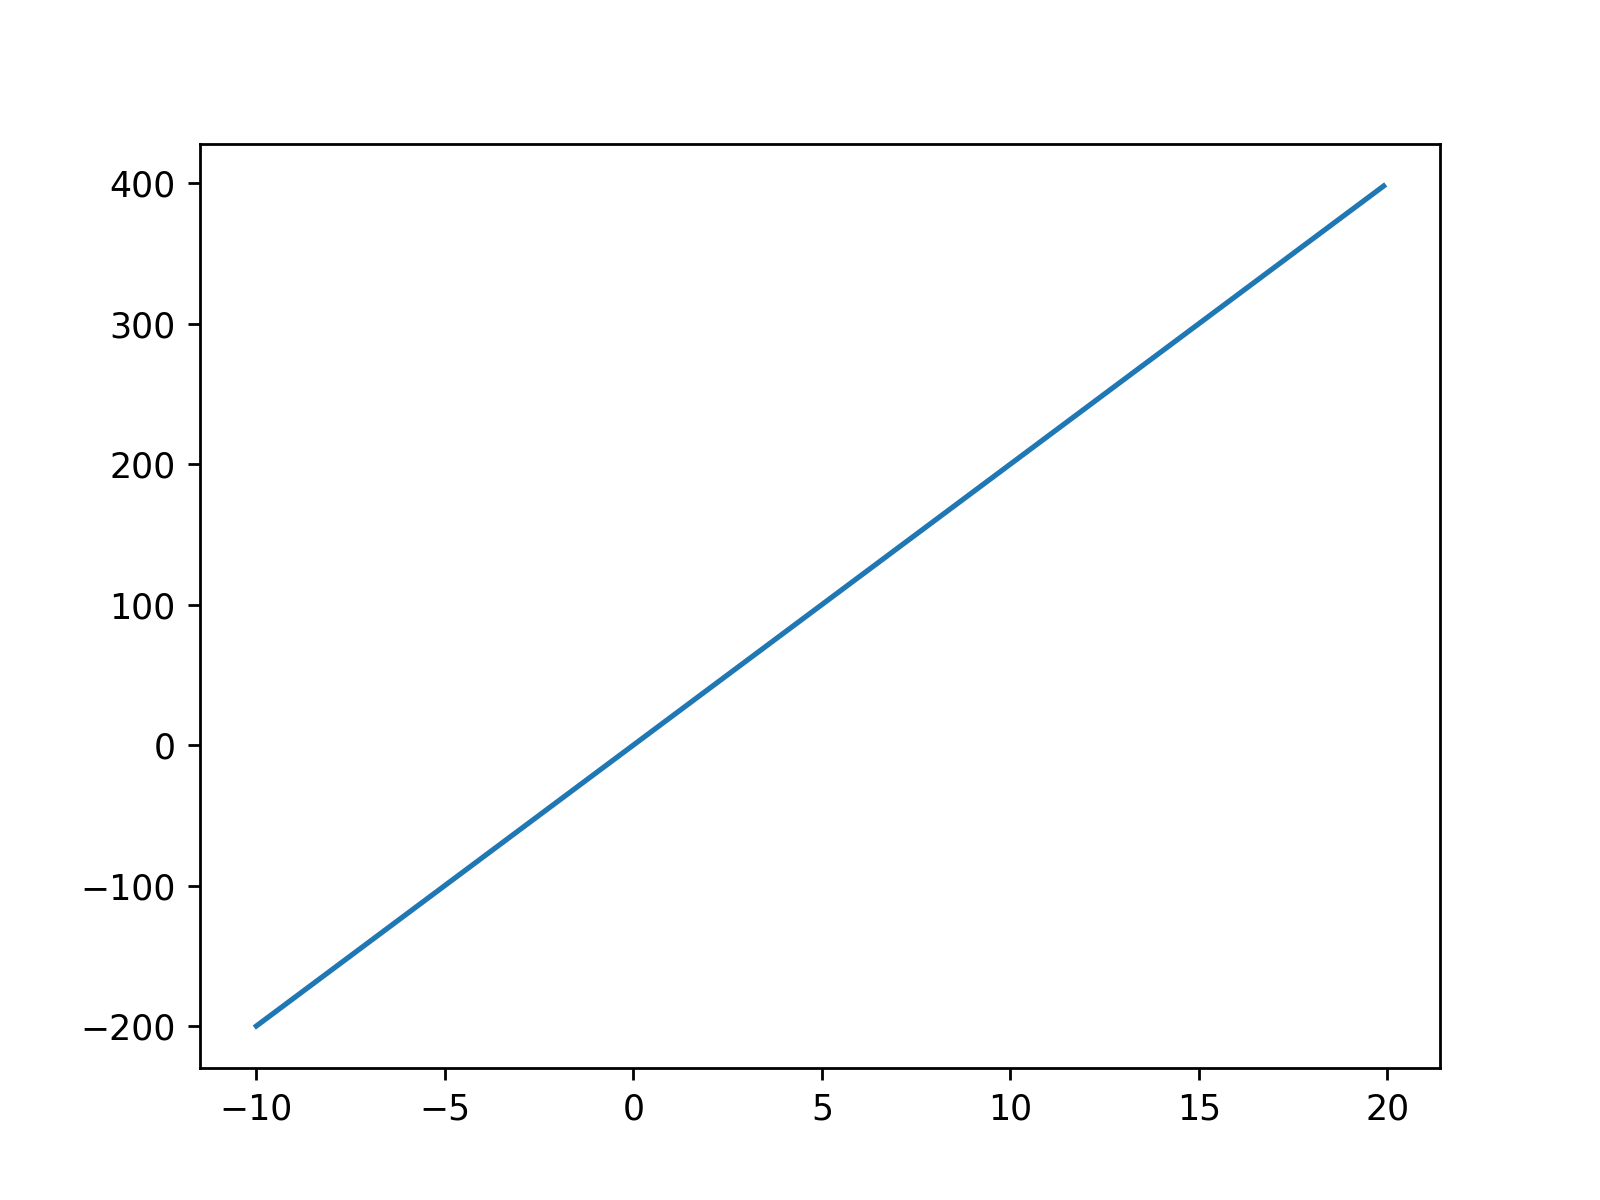

In [85]:
plt.figure()
plt.plot(original_extended_t, extended_position)

In [86]:
plateau_start_time = original_extended_t[plateau_start_index]

In [87]:
plateau_start_time

5.0

In [88]:
plateau_start_index = np.where(extended_t >= plateau_start_time)[0][0]

In [89]:
plateau_start_time, plateau_start_index

(5.0, 1500)

In [90]:
plateau_end_index = plateau_start_index + int(plateau_duration / dt)

In [91]:
plateau_in_time = np.zeros(len(extended_t))

In [92]:
plateau_in_time[plateau_start_index:plateau_end_index] = 1.

<IPython.core.display.Javascript object>


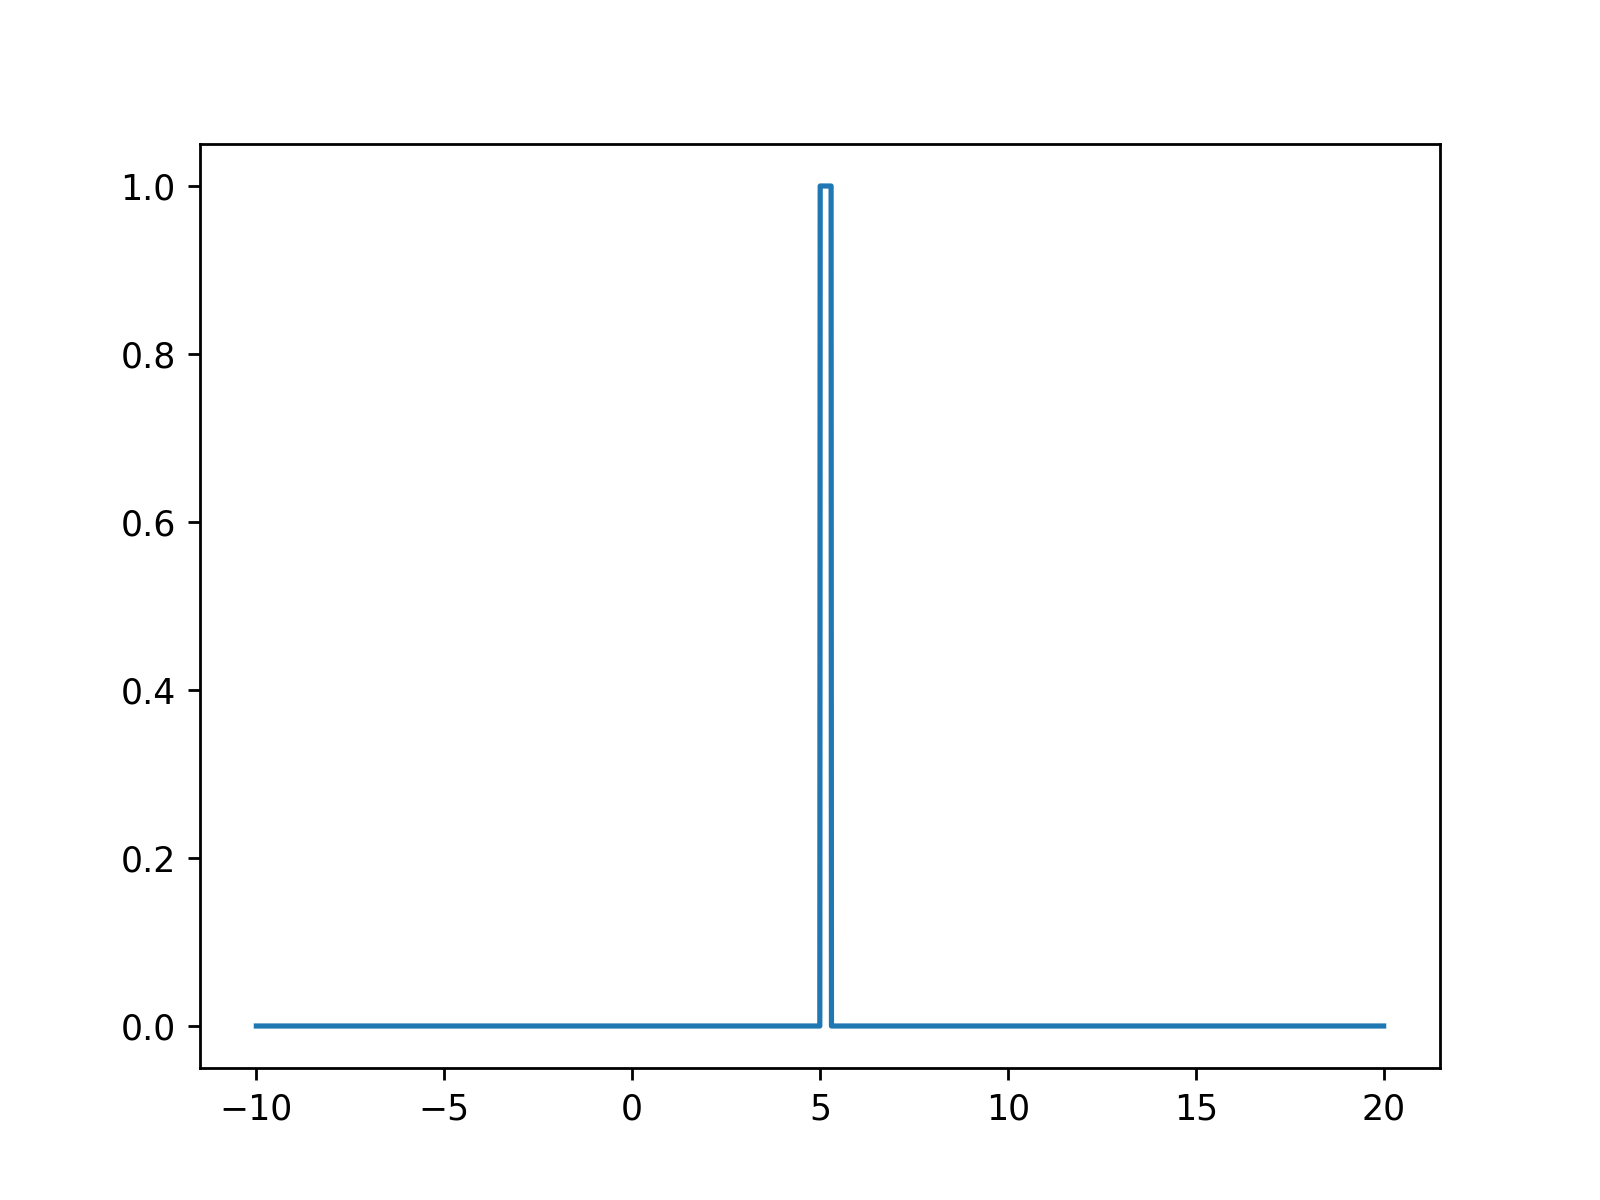

In [93]:
plt.figure()
plt.plot(extended_t, plateau_in_time)

In [94]:
tau_I = 0.75 # seconds
I_filter_t = np.arange(0., 6. * tau_I, dt)
I_filter = np.exp(-I_filter_t/tau_I)
I_filter /= np.sum(I_filter)

<IPython.core.display.Javascript object>


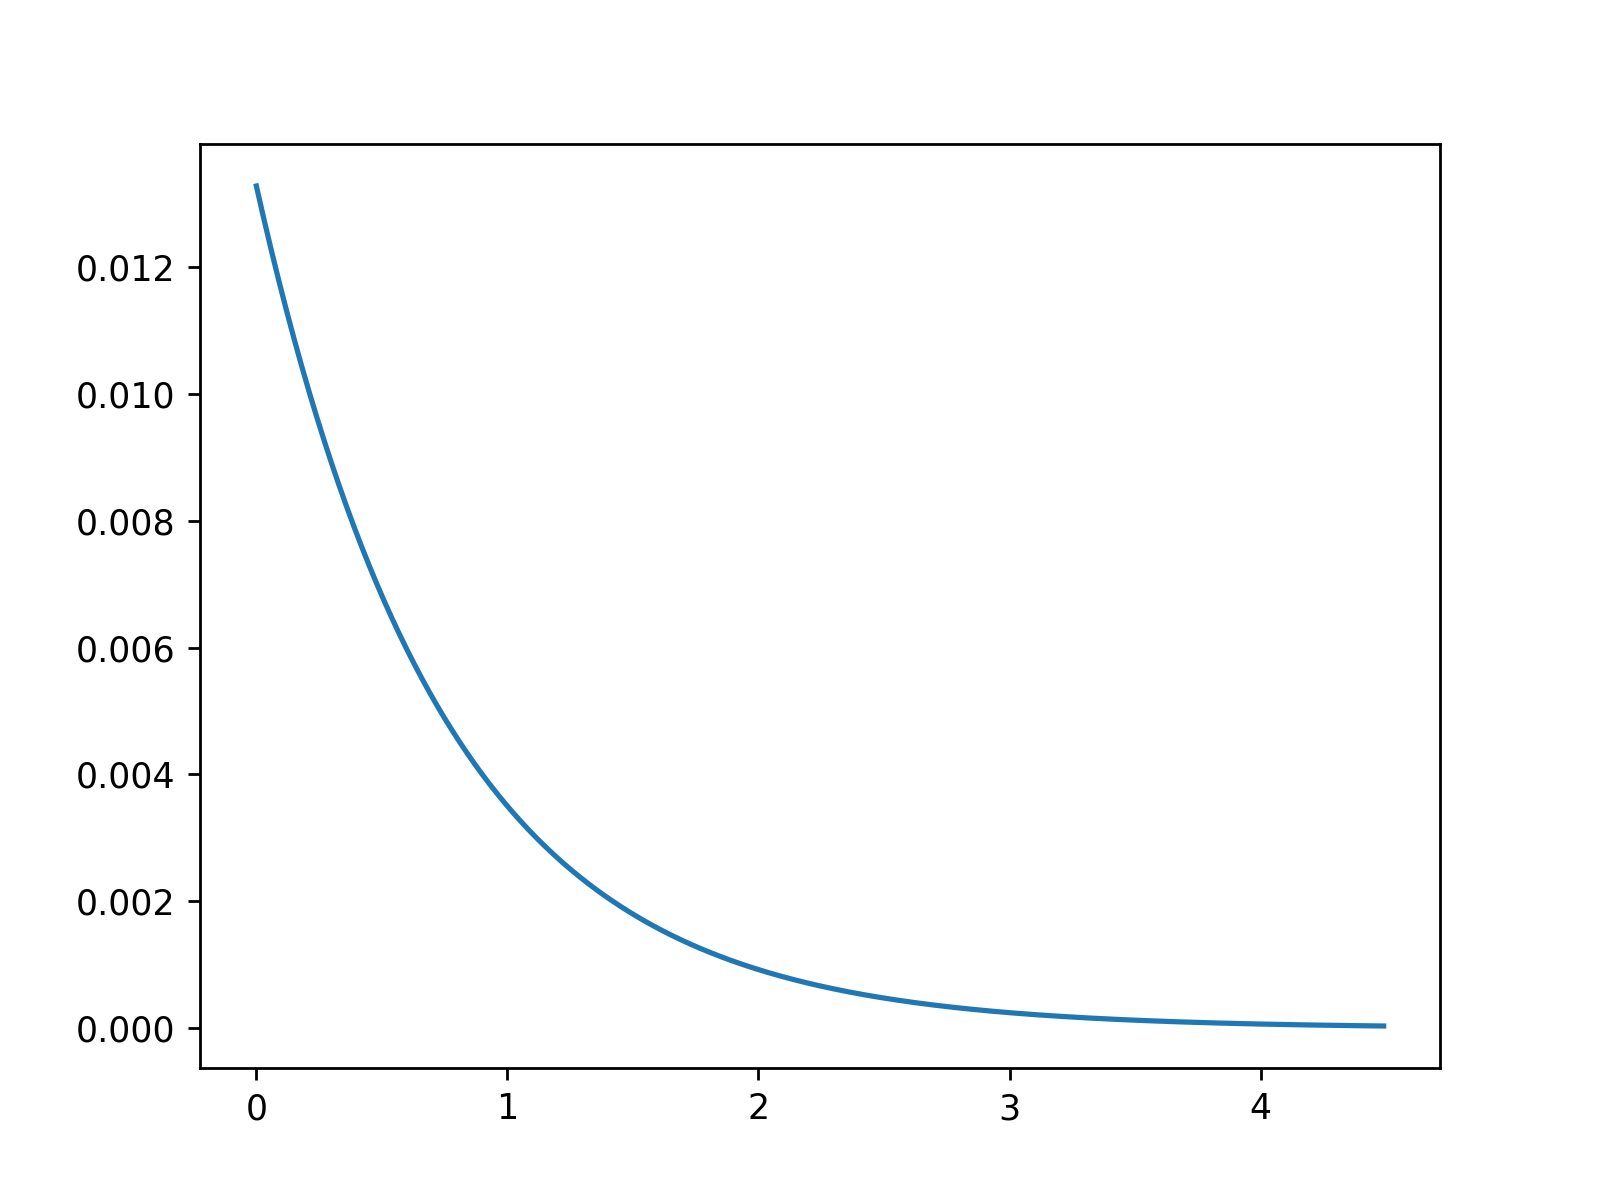

In [95]:
plt.figure()
plt.plot(I_filter_t, I_filter)

In [96]:
I_trace = np.convolve(plateau_in_time, I_filter, mode='full')[:len(extended_t)]

<IPython.core.display.Javascript object>


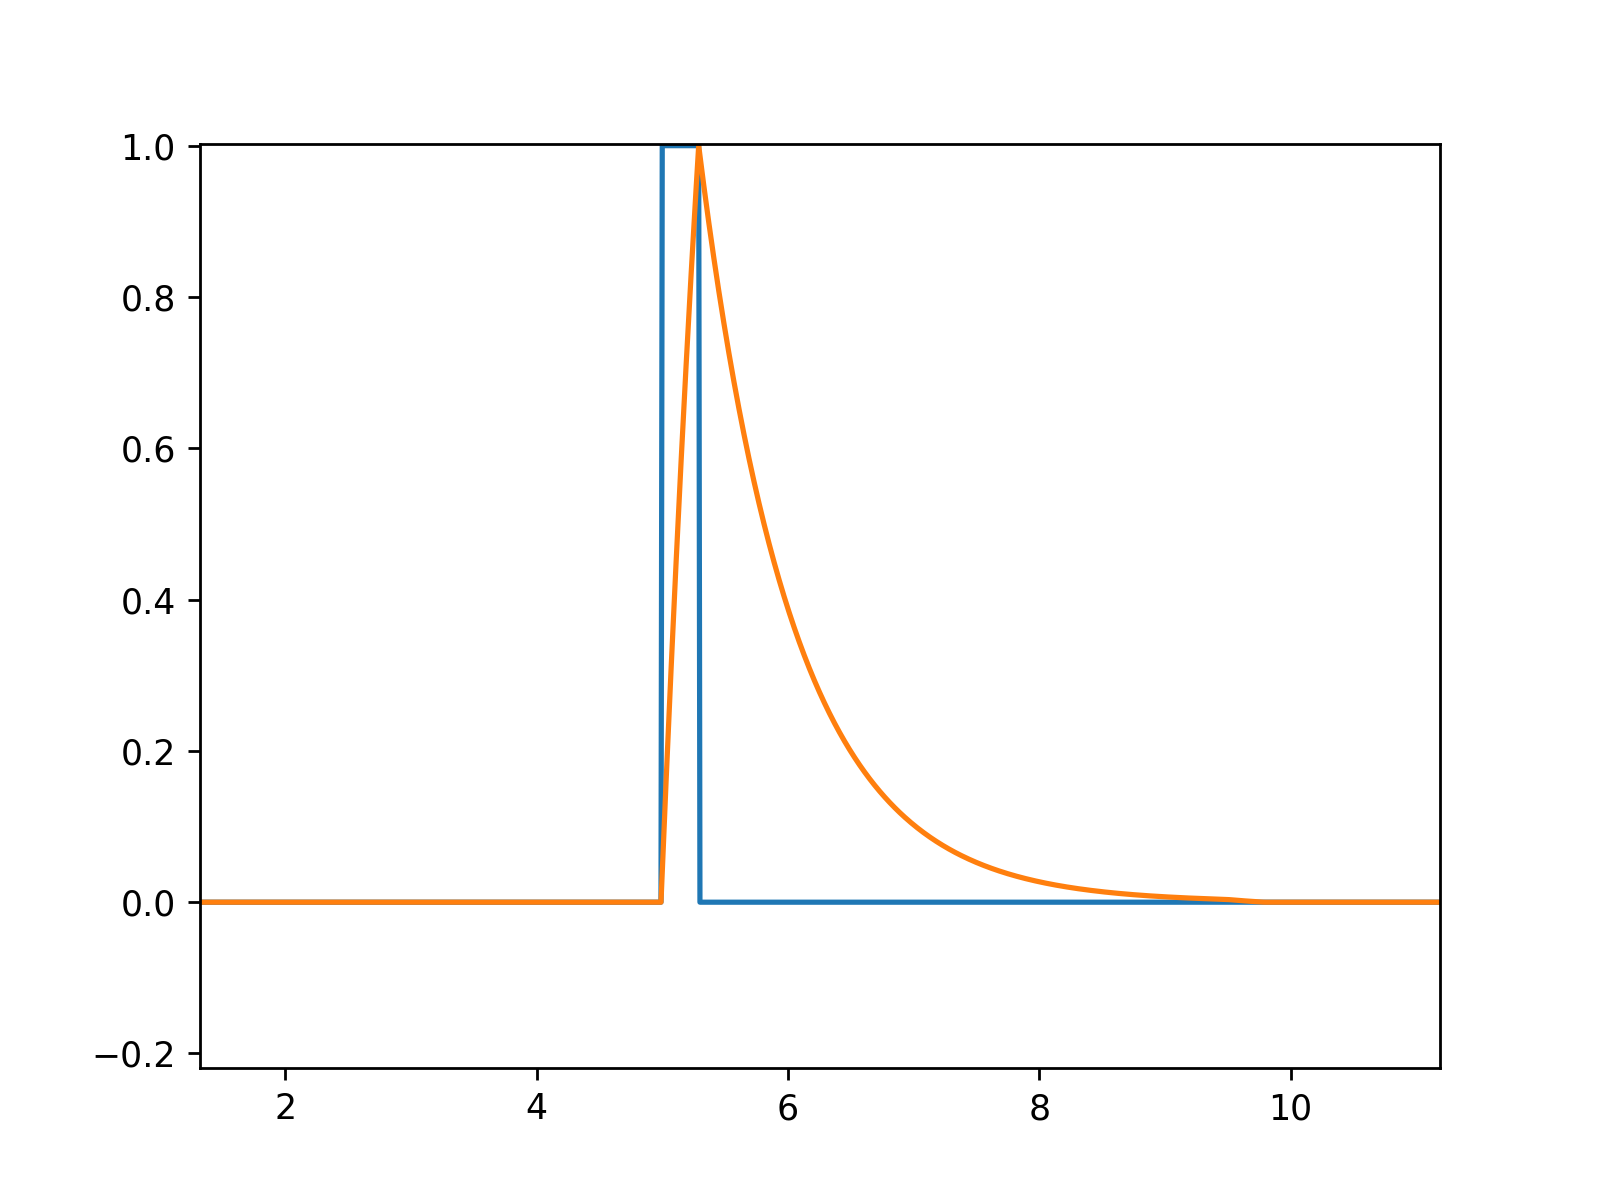

In [97]:
plt.figure()
plt.plot(extended_t, plateau_in_time)
plt.plot(extended_t, I_trace / np.max(I_trace))

In [98]:
E_trace_matrix = np.empty_like(pre_rate_in_time_matrix)
for i, pre_rate in enumerate(pre_rate_in_time_matrix):
    E_trace_matrix[i,:] = np.convolve(pre_rate, E_filter, mode='full')[:len(extended_t)]

In [129]:
E_trace_matrix /= np.max(E_trace_matrix)
I_trace /= np.max(I_trace)

<IPython.core.display.Javascript object>


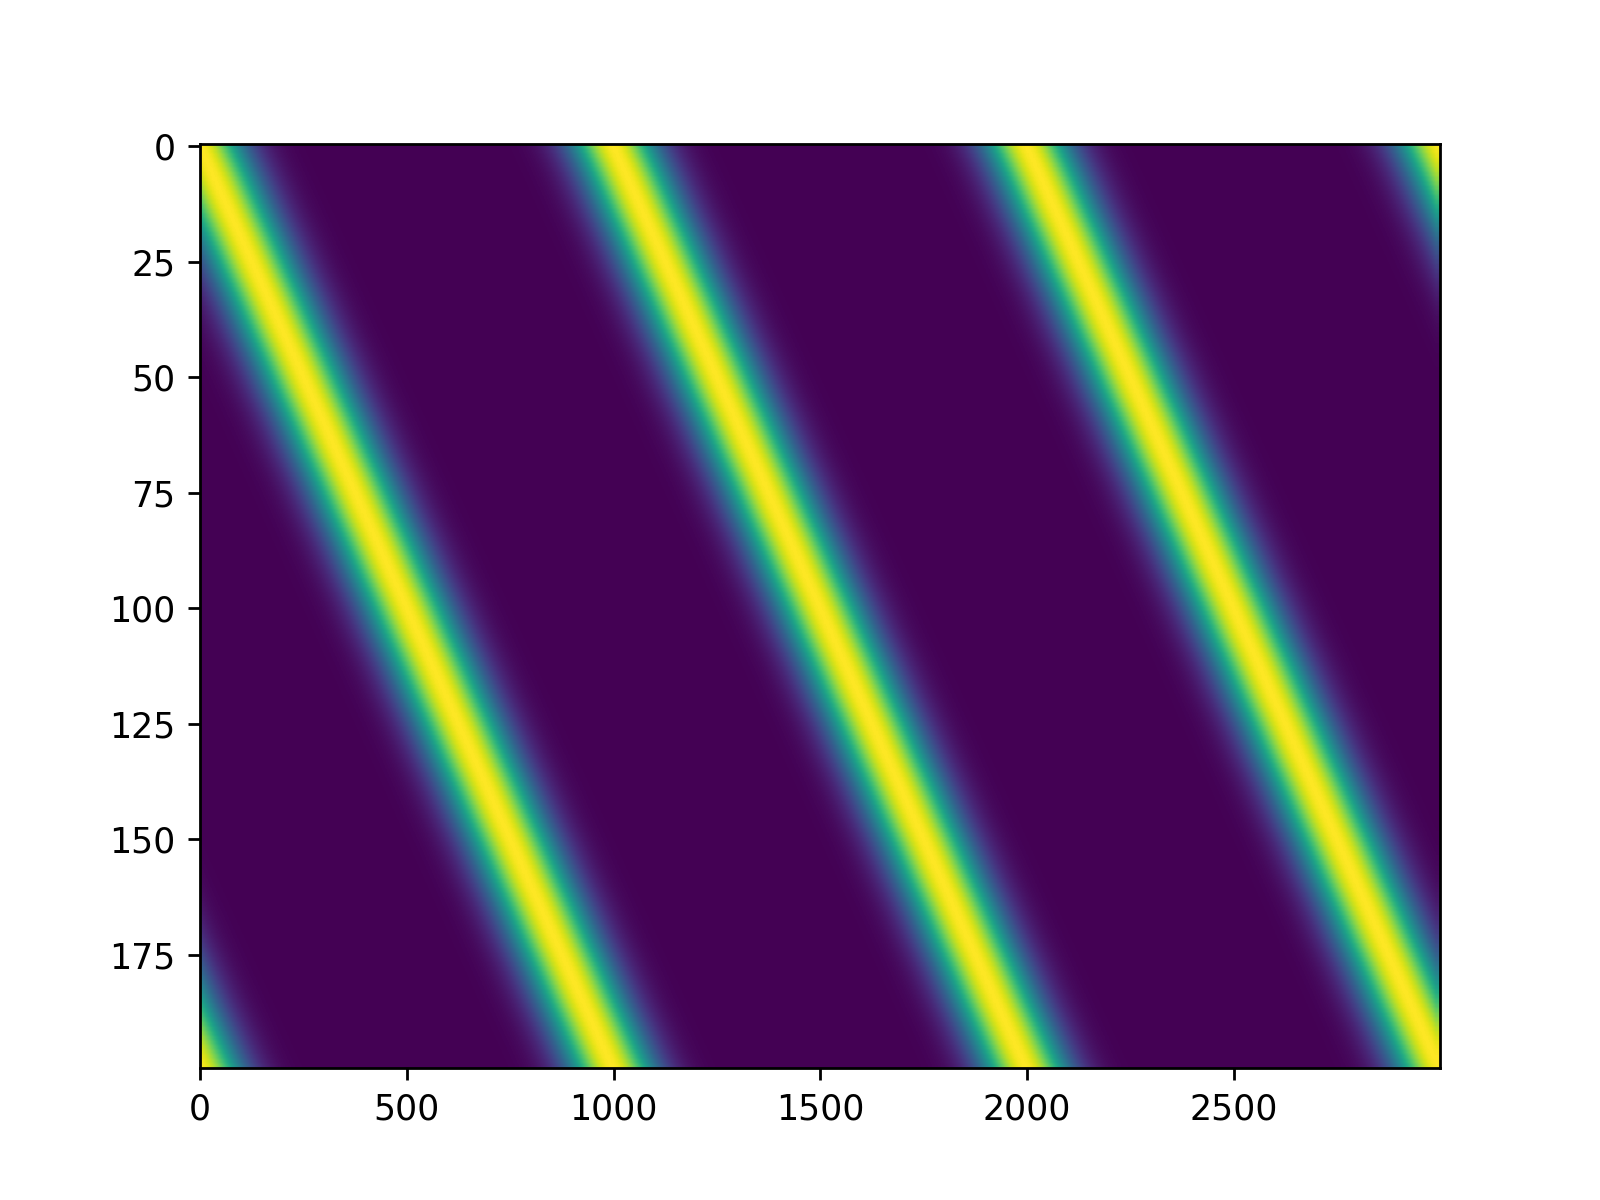

<IPython.core.display.Javascript object>


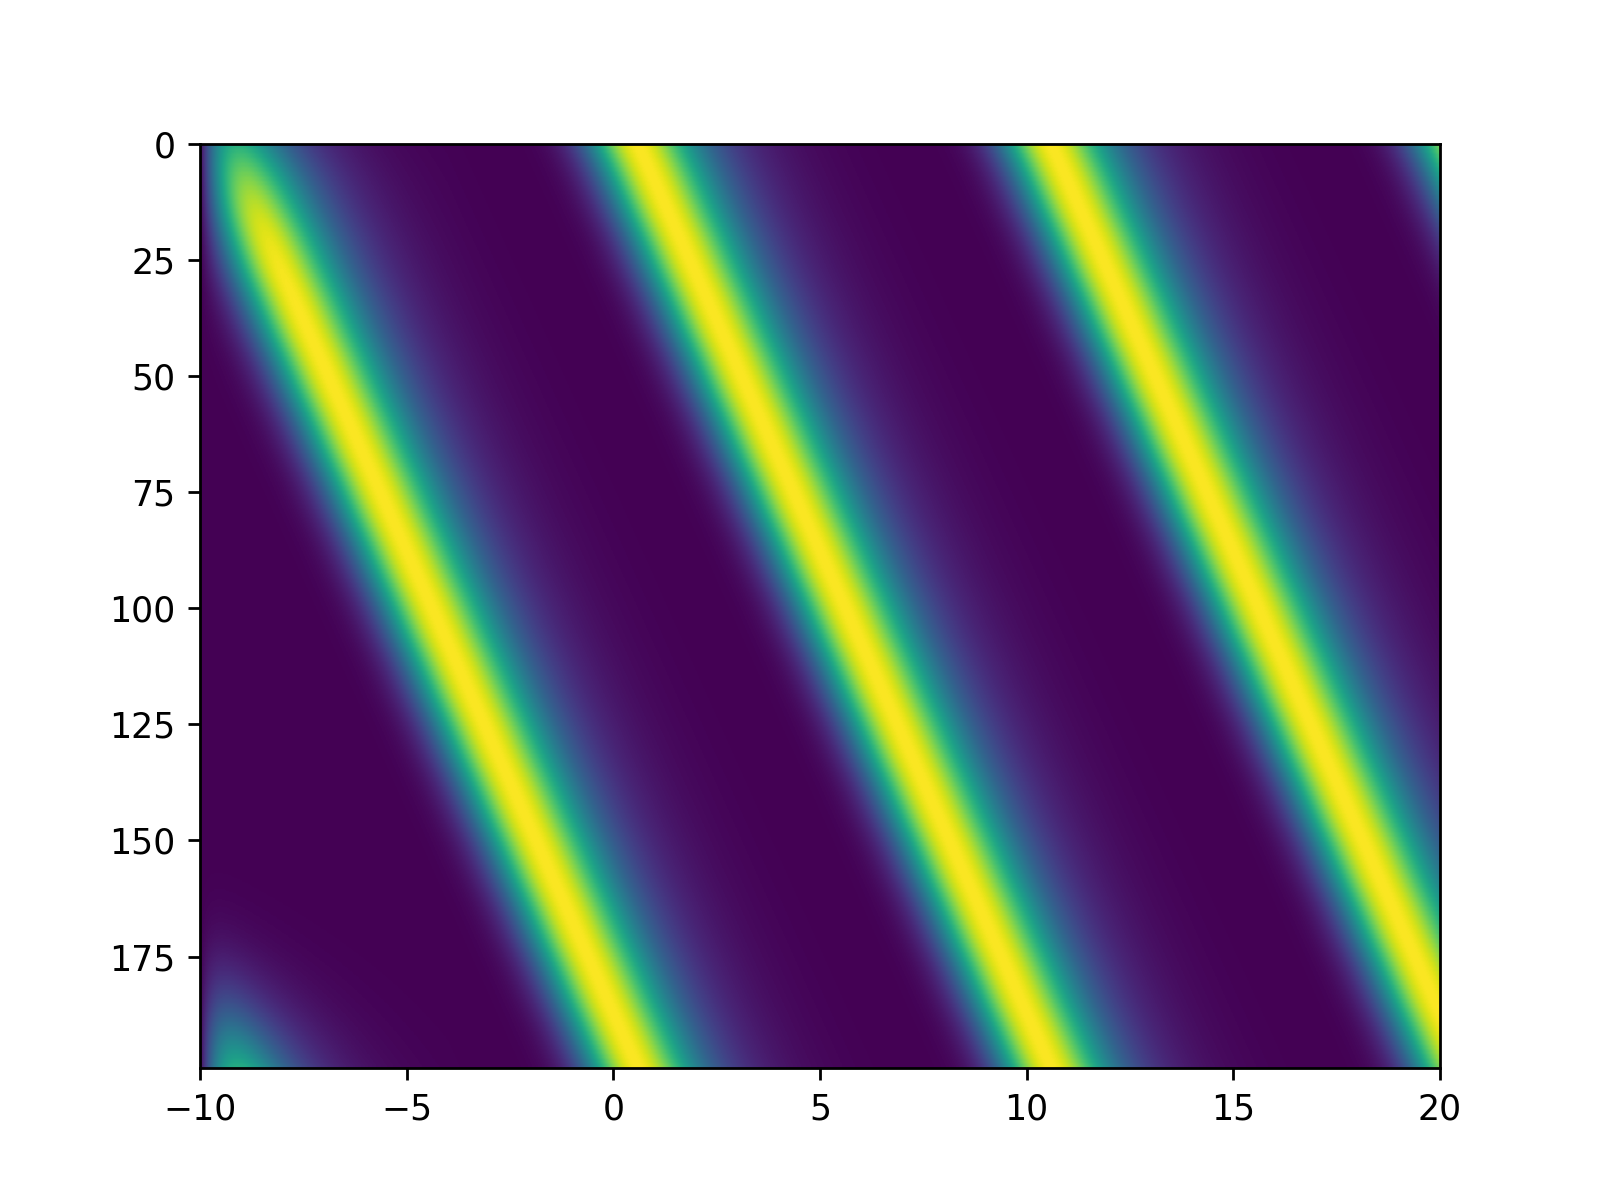

In [130]:
plt.figure()
plt.imshow(pre_rate_in_time_matrix, aspect='auto')
plt.figure()
plt.imshow(E_trace_matrix, aspect='auto', extent=[-duration, 2. * duration, num_inputs-1, 0])


In [131]:
signal_overlap_matrix = np.empty_like(pre_rate_in_time_matrix)
for i, E_trace in enumerate(E_trace_matrix):
    signal_overlap_matrix[i,:] = np.multiply(E_trace, I_trace)

<IPython.core.display.Javascript object>


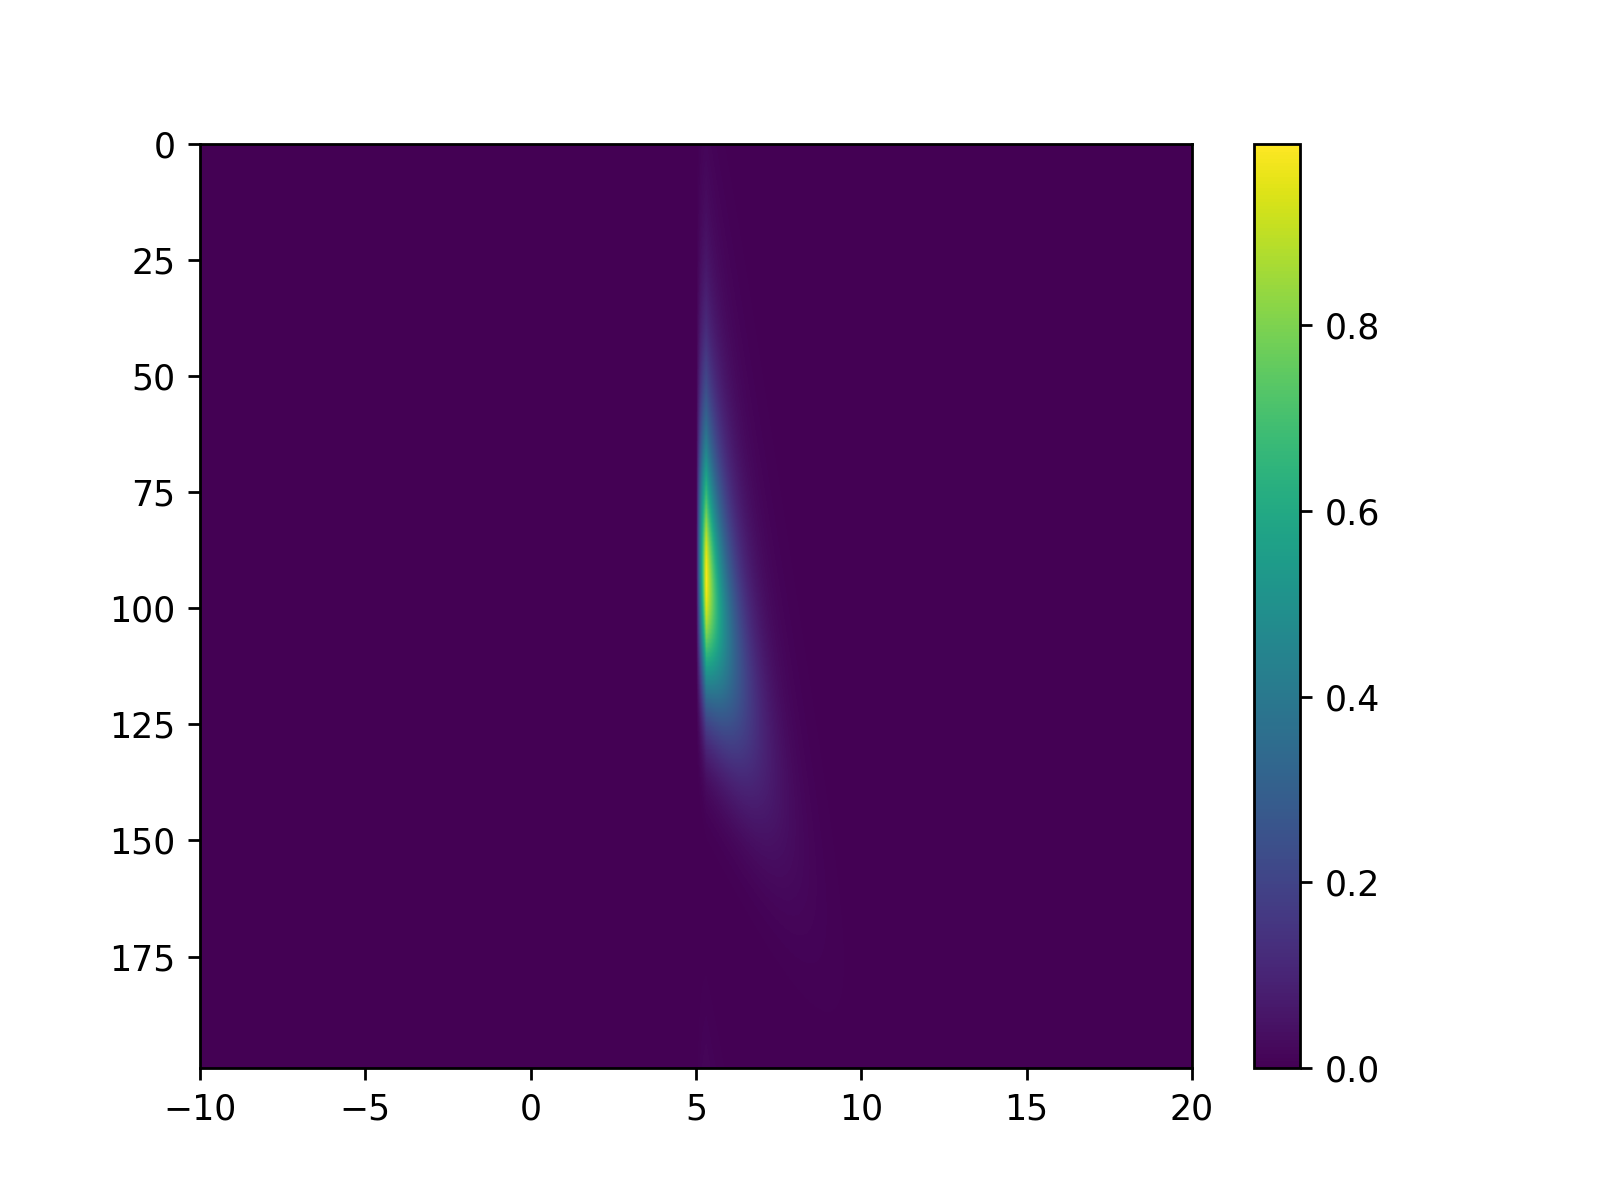

In [133]:
plt.figure()
plt.imshow(signal_overlap_matrix, aspect='auto', extent=[-duration, 2. * duration, num_inputs-1, 0])
plt.colorbar()

In [104]:
signal_range = np.linspace(0., 1., 1000)

In [105]:
example_sigmoid = lambda signal_range, slope, threshold: 1. / (1. + np.exp(-slope*(signal_range - threshold)))

/Users/aaronmil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


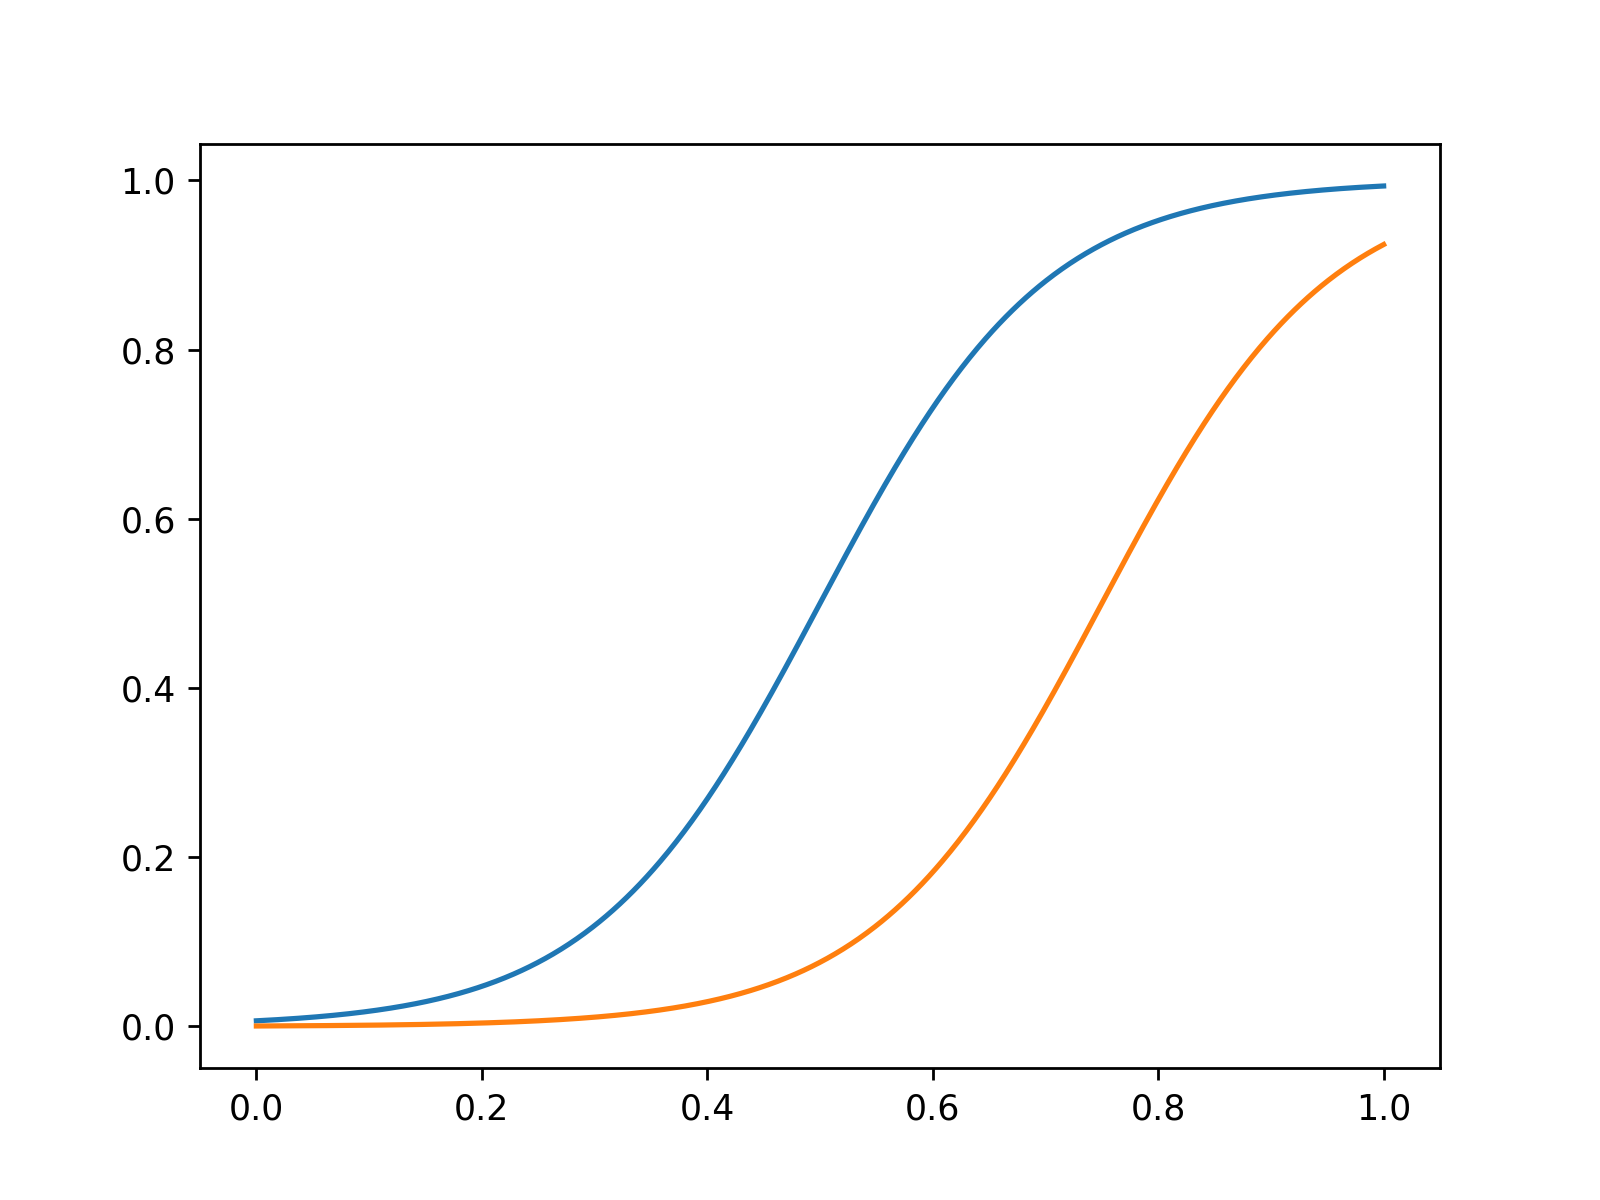

In [106]:
plt.figure()
original = example_sigmoid(signal_range, 10., 0.5)
plt.plot(signal_range, original)
plt.plot(signal_range, example_sigmoid(signal_range, 10., 0.75))

In [107]:
def scaled_single_sigmoid(th, peak, x=None, ylim=None):
    """
    Transform a sigmoid to intersect x and y range limits.
    :param th: float
    :param peak: float
    :param x: array
    :param ylim: pair of float
    :return: callable
    """
    if x is None:
        x = (0., 1.)
    if ylim is None:
        ylim = (0., 1.)
    if th < x[0] or th > x[-1]:
        raise ValueError('scaled_single_sigmoid: th: %.2E is out of range for xlim: [%.2E, %.2E]' % (th, x[0], x[-1]))
    if peak == th:
        raise ValueError('scaled_single_sigmoid: peak and th: %.2E cannot be equal' % th)
    slope = 2. / (peak - th)
    y = lambda x: 1. / (1. + np.exp(-slope * (x - th)))
    start_val = y(x[0])
    end_val = y(x[-1])
    amp = end_val - start_val
    target_amp = ylim[1] - ylim[0]
    return lambda xi: (target_amp / amp) * (1. / (1. + np.exp(-slope * (xi - th))) - start_val) + ylim[0]

In [108]:
this_scaled_sigmoid = scaled_single_sigmoid(0.25, 0.5)

<IPython.core.display.Javascript object>


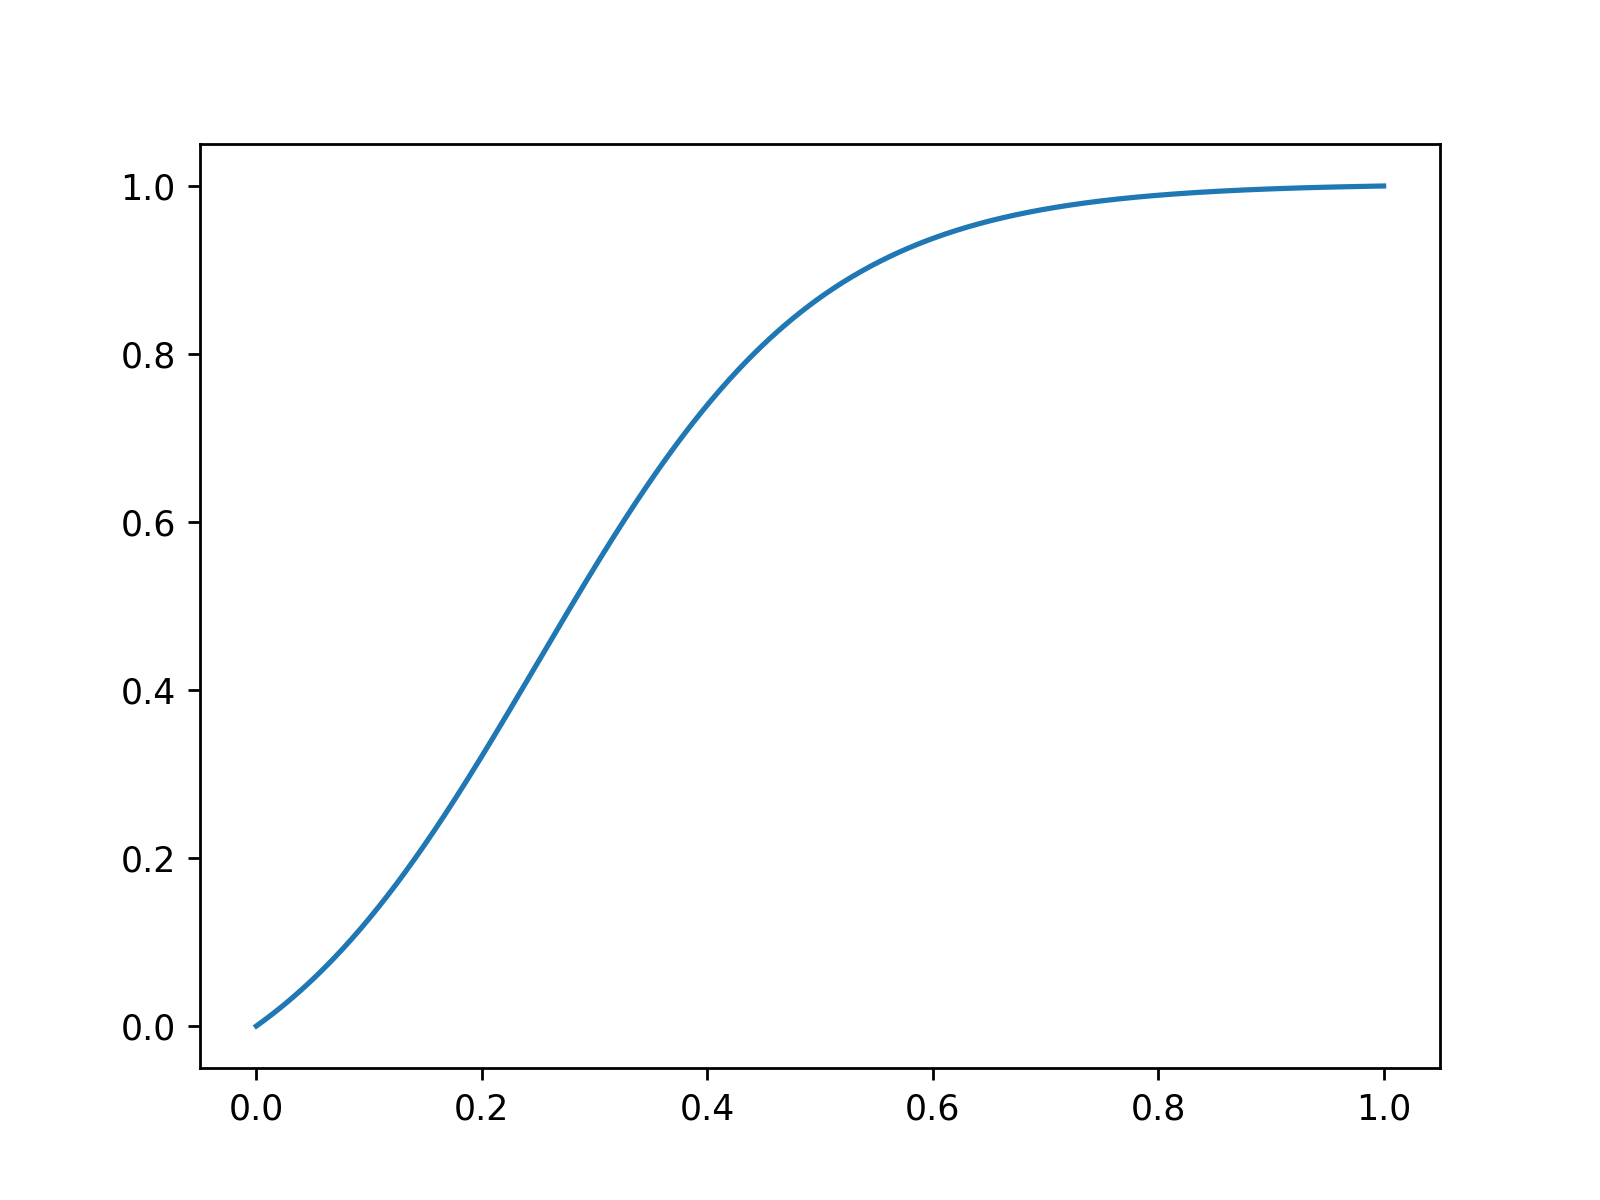

In [109]:
plt.figure()
plt.plot(signal_range, this_scaled_sigmoid(signal_range))

In [110]:
example_potentiation = scaled_single_sigmoid(0.50, 0.75)
example_depression = scaled_single_sigmoid(0.25, 0.5)

<IPython.core.display.Javascript object>


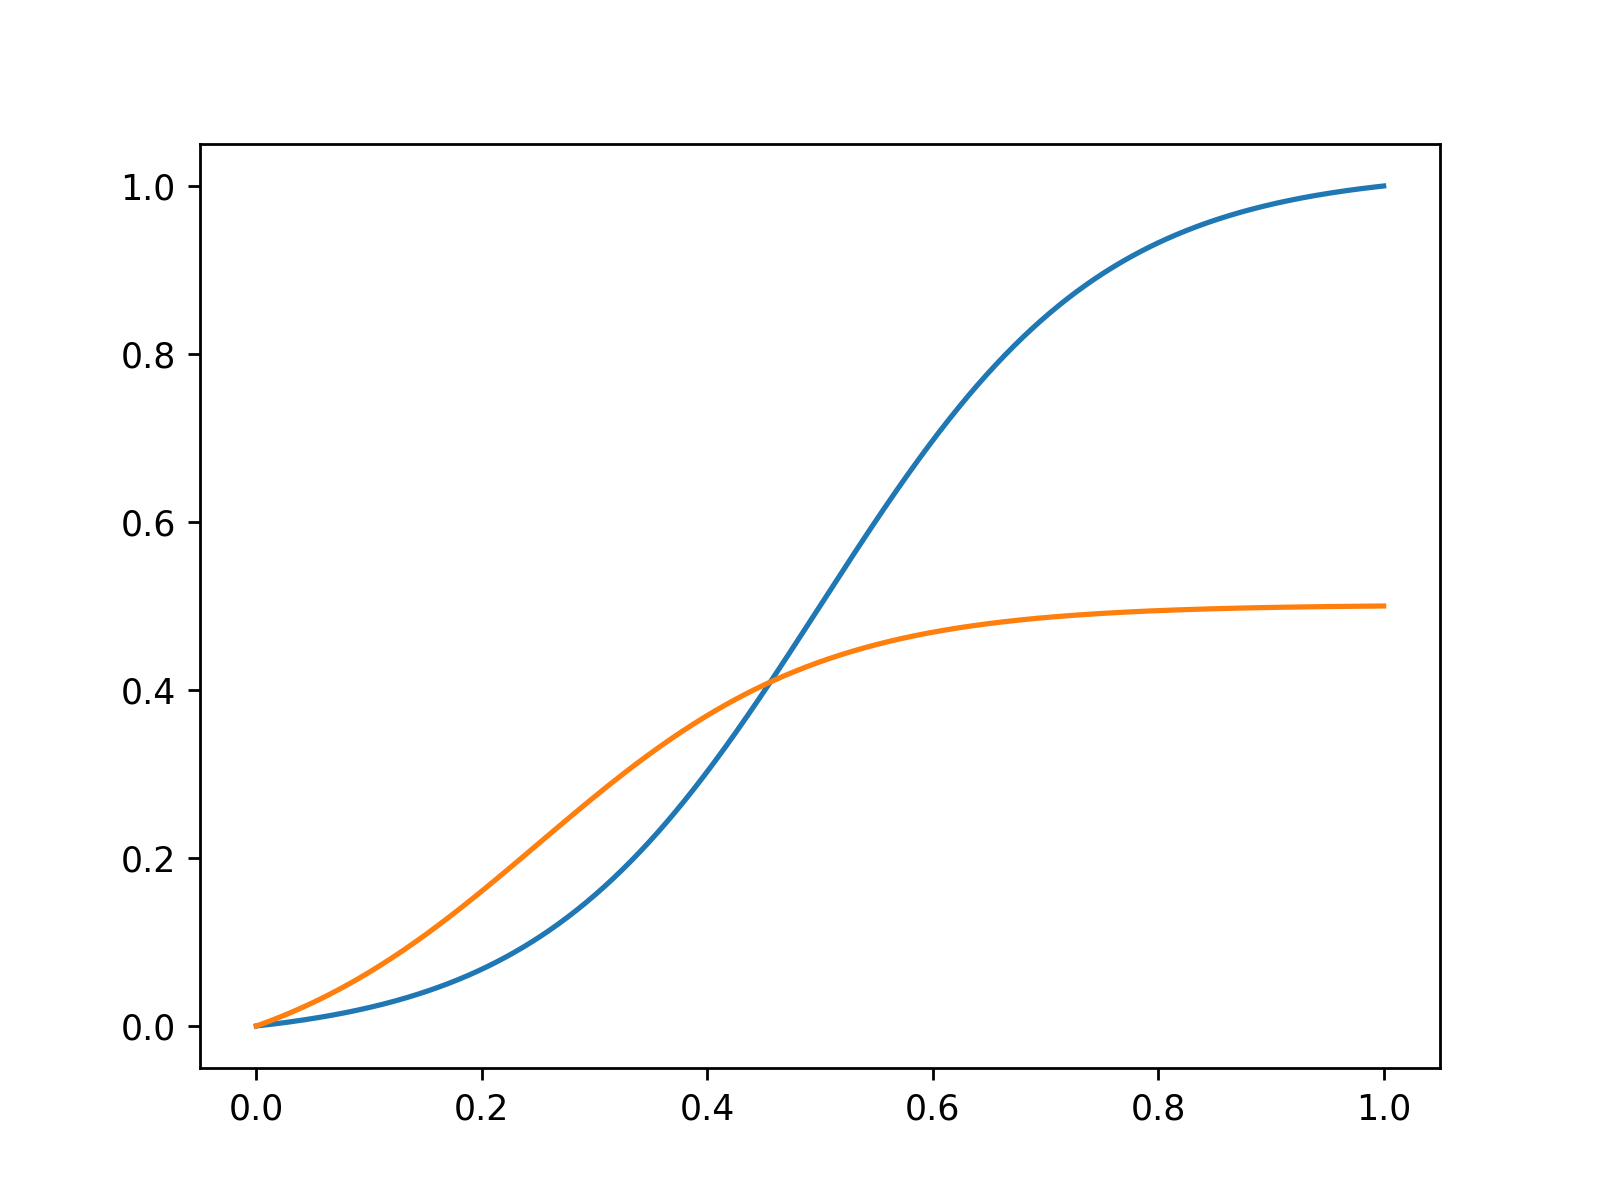

<IPython.core.display.Javascript object>


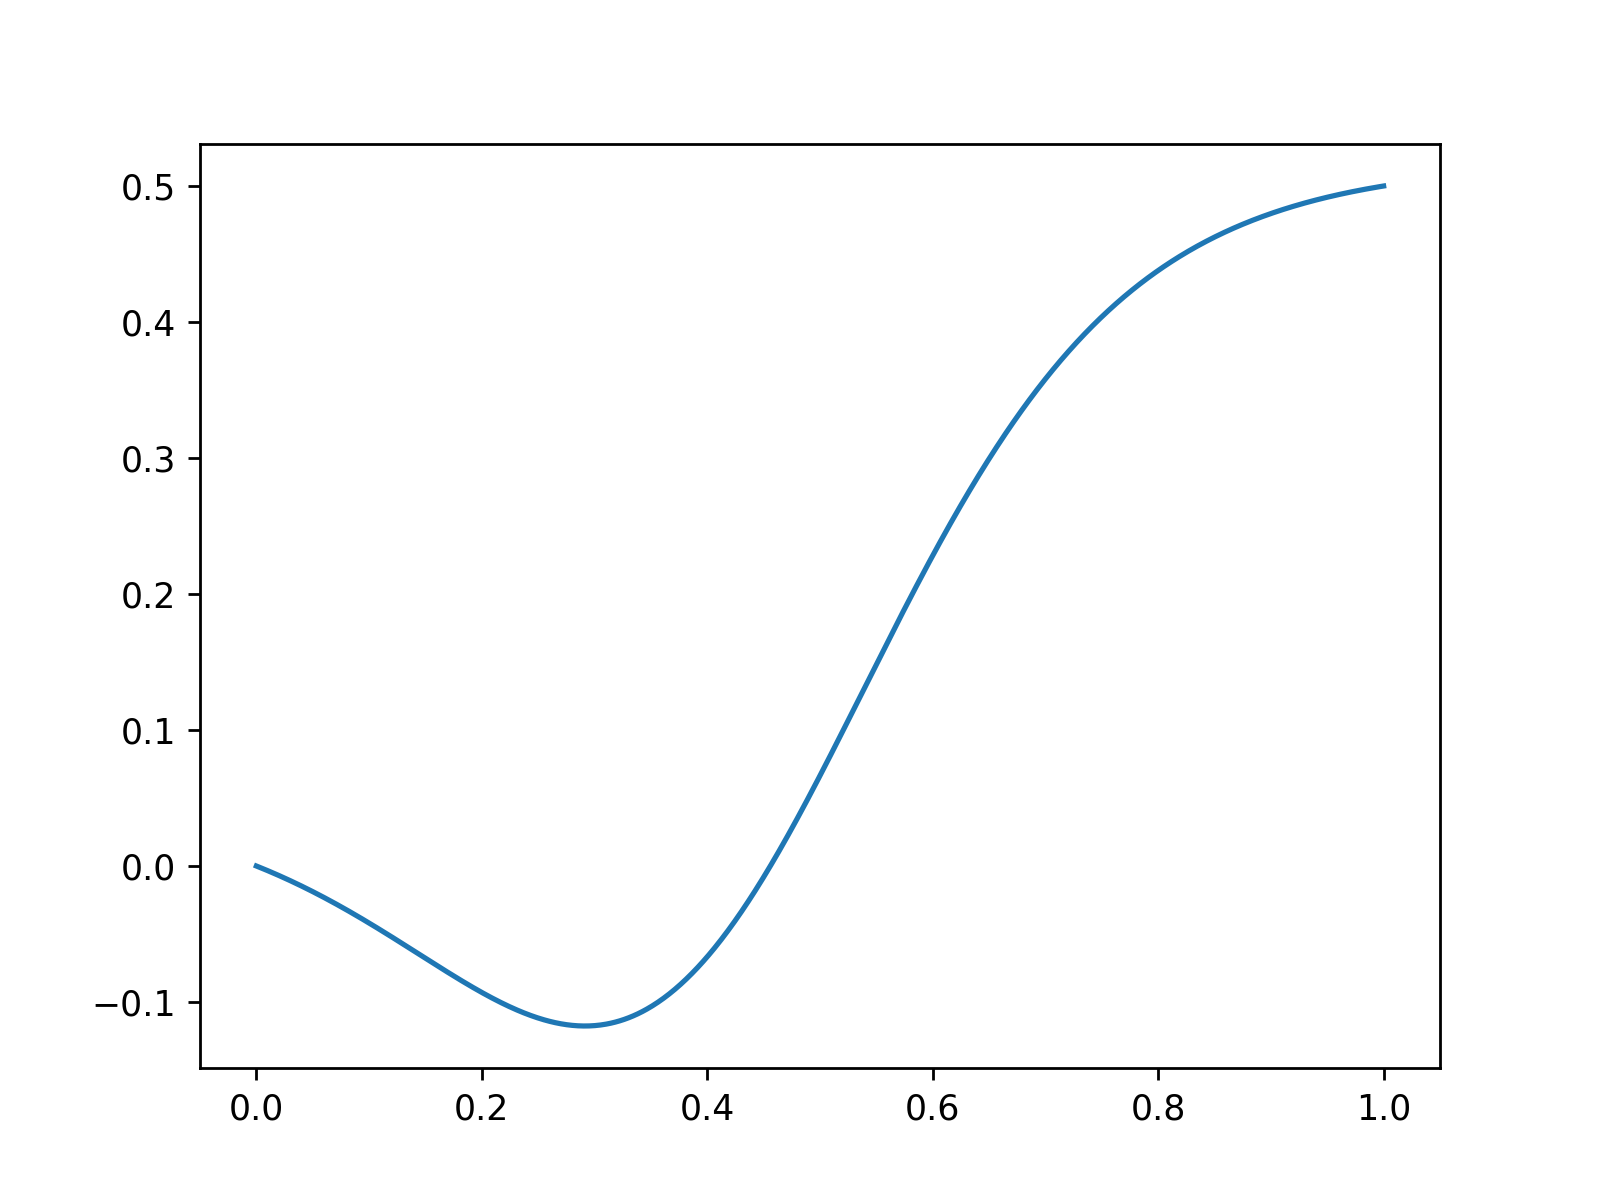

In [111]:
depression_ratio = 0.5
linear_potentiation = lambda x: x
plt.figure()
plt.plot(signal_range, example_potentiation(signal_range))
plt.plot(signal_range, depression_ratio * example_depression(signal_range))

plt.figure()
plt.plot(signal_range, example_potentiation(signal_range) - depression_ratio * example_depression(signal_range))

In [114]:
W_max = 3.
dW_dt = lambda x, W, W_max: (W_max - W) * example_potentiation(x) - depression_ratio * W * example_depression(x)

<IPython.core.display.Javascript object>


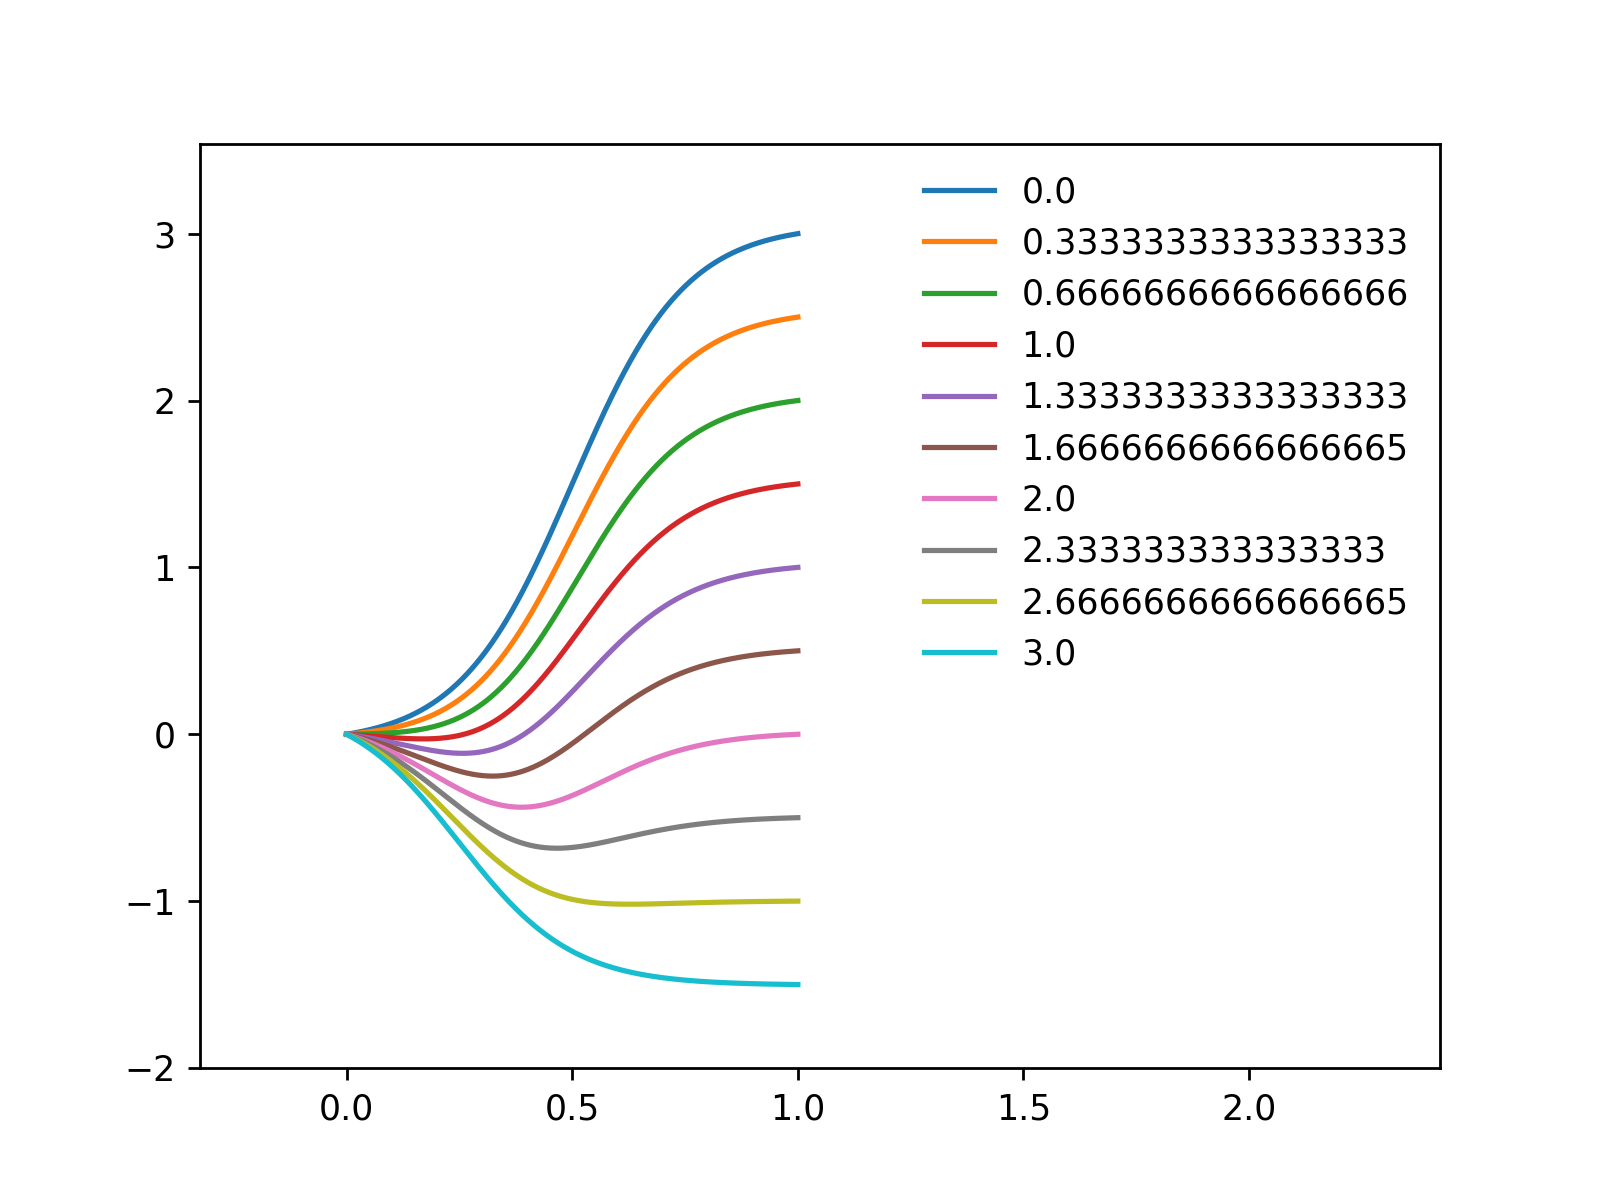

In [116]:
plt.figure()
for W0 in np.linspace(0., W_max, 10):
    plt.plot(signal_range, dW_dt(signal_range, W0, W_max), label=W0)
plt.legend(loc='best', frameon=False)

<IPython.core.display.Javascript object>


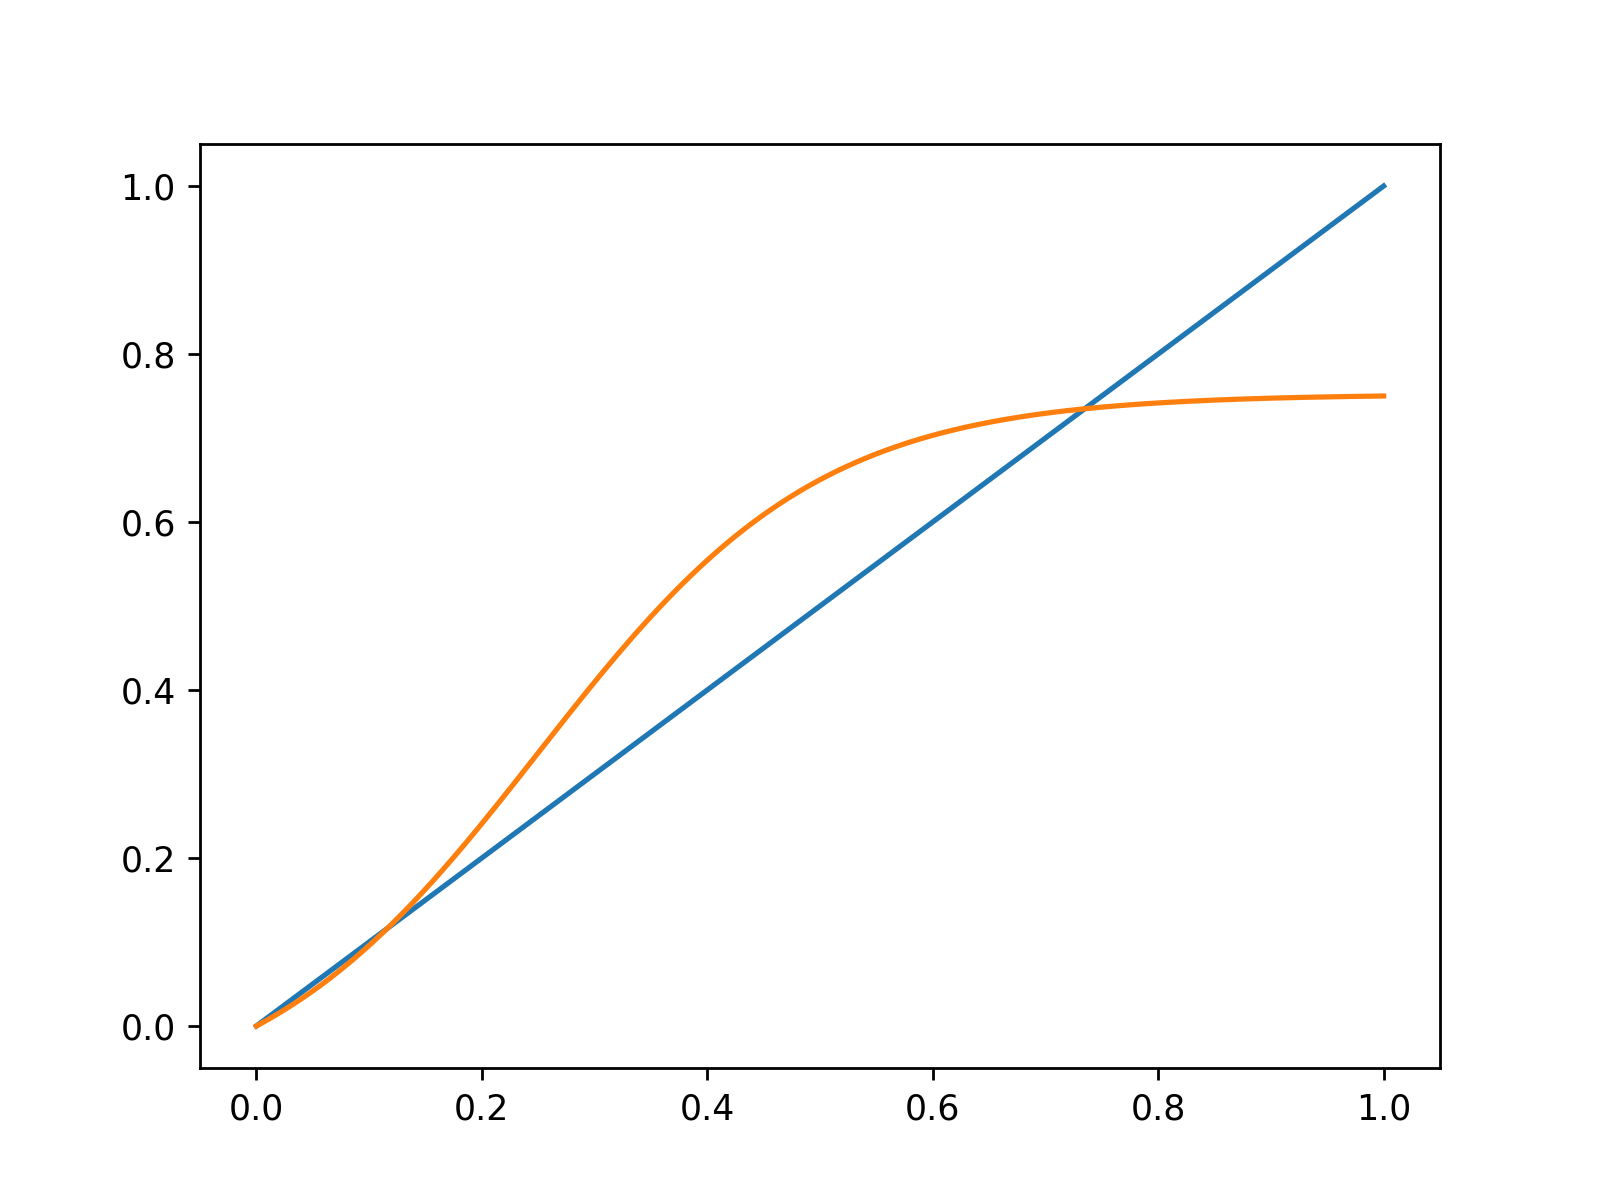

<IPython.core.display.Javascript object>


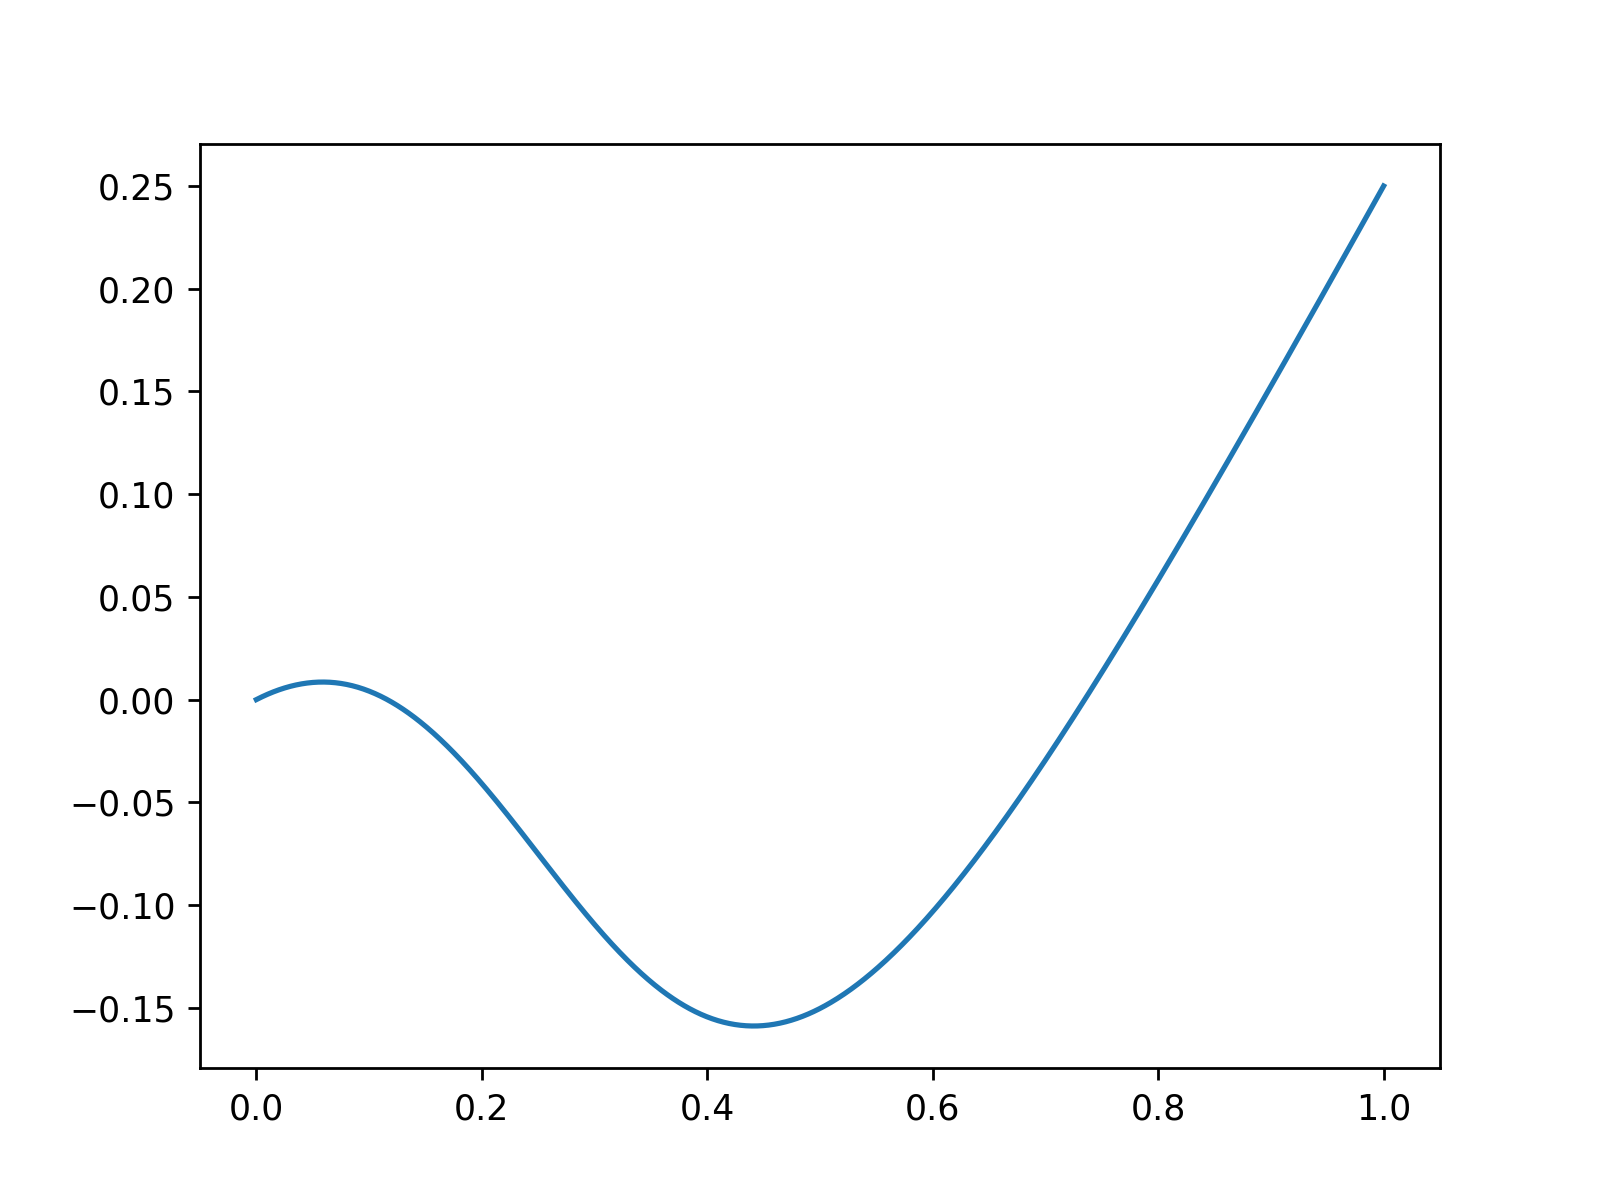

In [207]:
depression_ratio = 0.75
linear_potentiation = lambda x: x
plt.figure()
plt.plot(signal_range, linear_potentiation(signal_range))
plt.plot(signal_range, depression_ratio * example_depression(signal_range))

plt.figure()
plt.plot(signal_range, linear_potentiation(signal_range) - depression_ratio * example_depression(signal_range))

In [134]:
dW_dt_matrix = np.empty_like(pre_rate_in_time_matrix)
for i, signal_overlap in enumerate(signal_overlap_matrix):
    dW_dt_matrix[i,:] = dW_dt(signal_overlap, silent_weights[i], W_max)

<IPython.core.display.Javascript object>


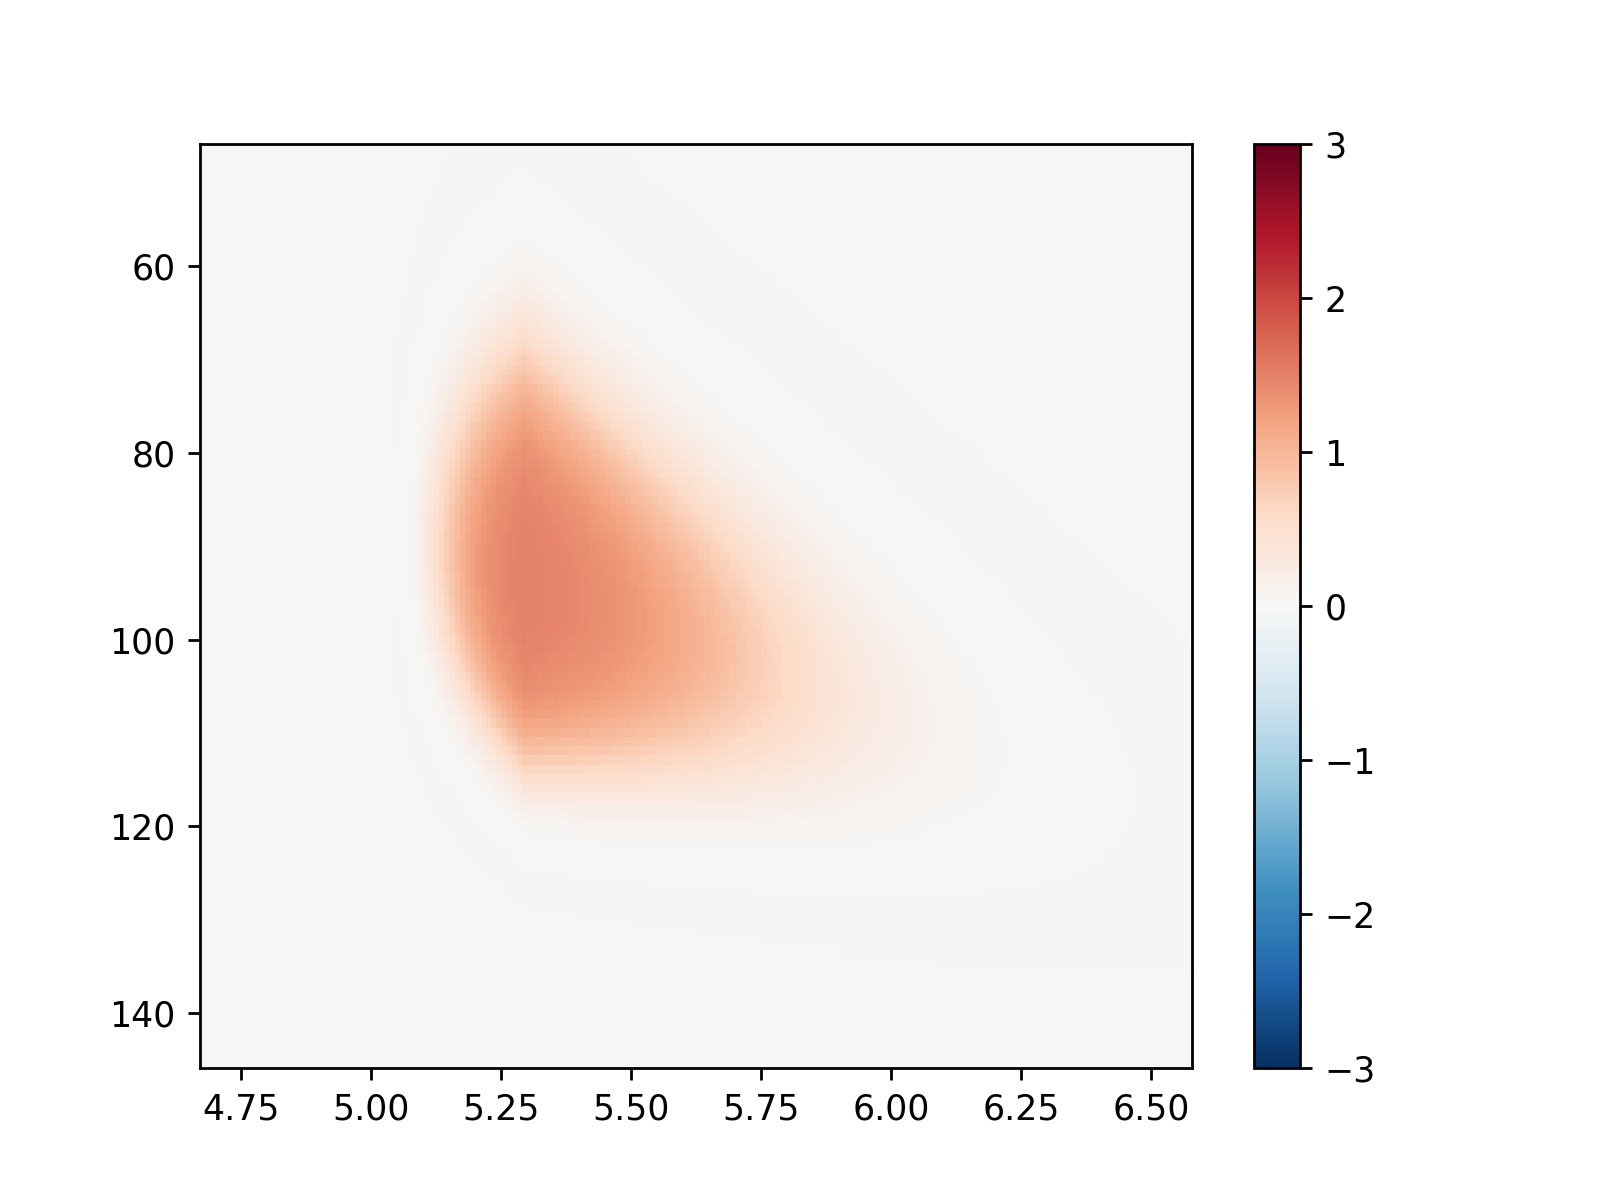

In [139]:
plt.figure()
plt.imshow(dW_dt_matrix, cmap='RdBu_r', aspect='auto', extent=[-duration, 2. * duration, num_inputs-1, 0], vmin=-W_max, vmax=W_max)
plt.colorbar()

In [142]:
silent_delta_weights = np.empty_like(silent_weights)
for i, this_dW_dt in enumerate(dW_dt_matrix):
    silent_delta_weights[i] = np.trapz(this_dW_dt, dx=dt)

<IPython.core.display.Javascript object>


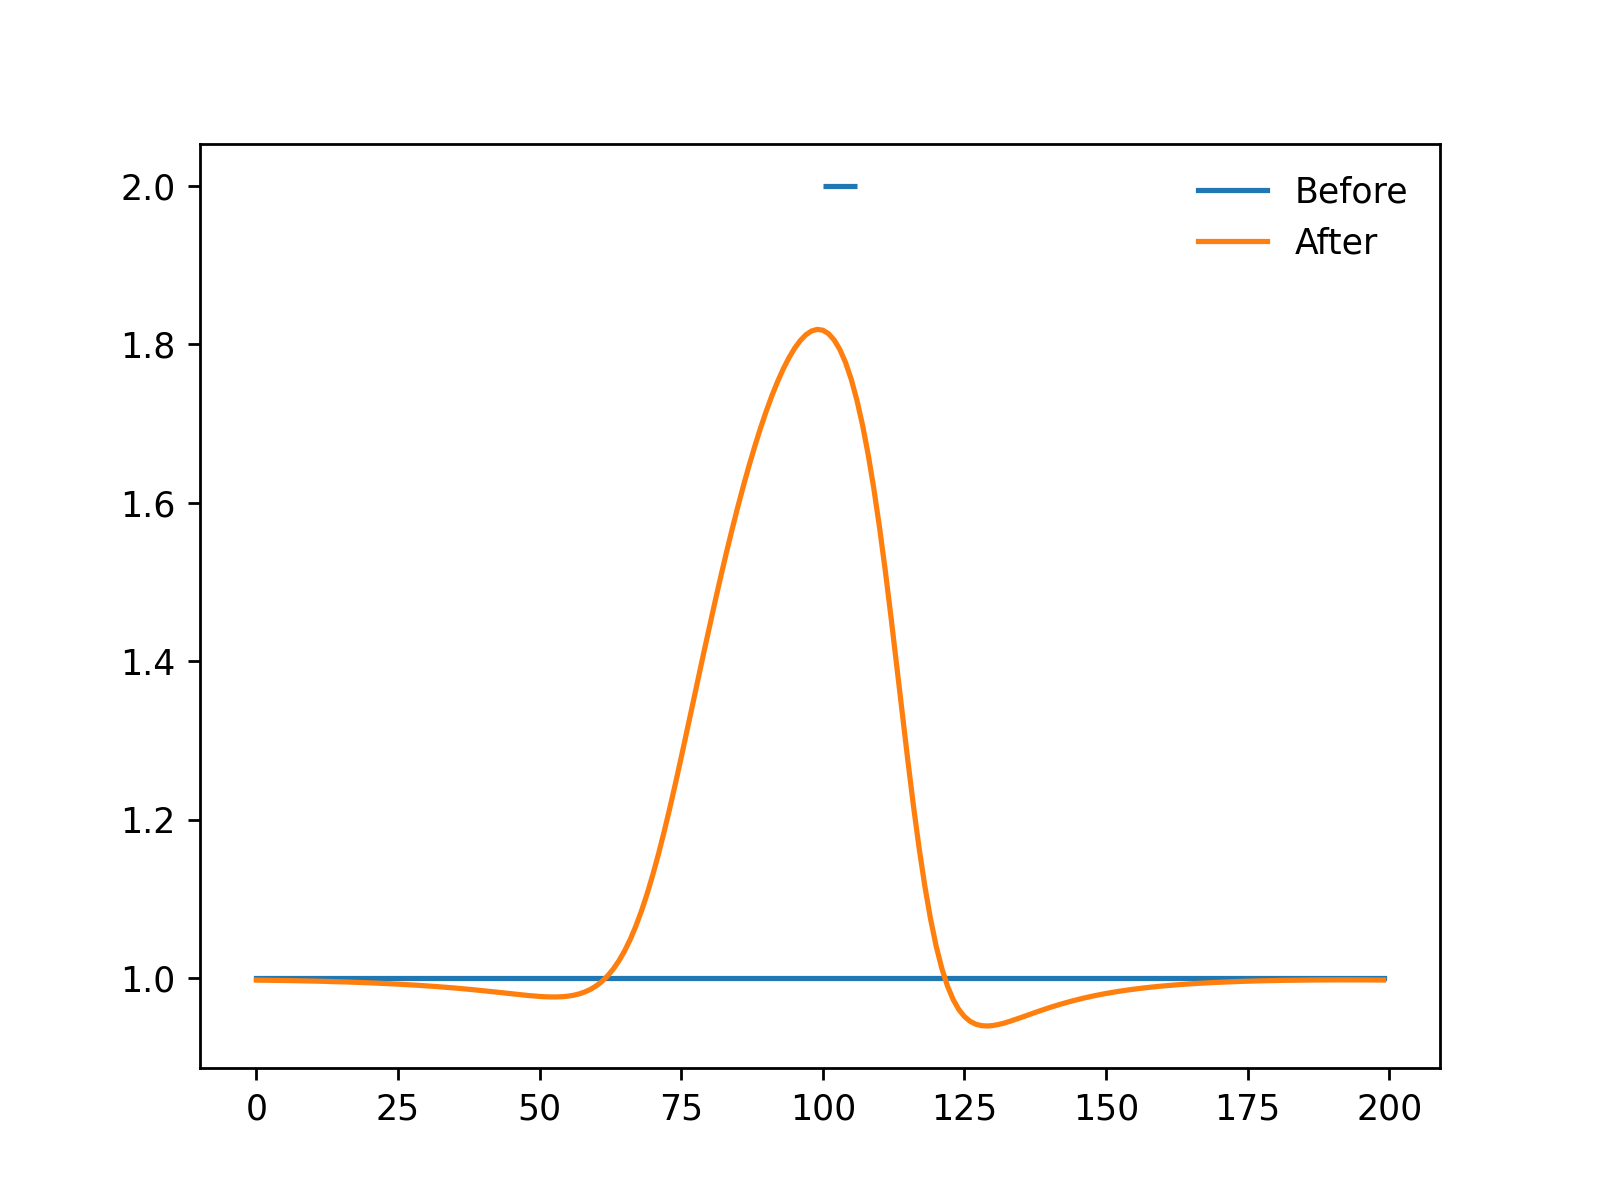

In [144]:
plt.figure()
plt.plot(peak_locs, silent_weights, label='Before')
plt.plot(peak_locs, silent_weights + silent_delta_weights, label='After')
plt.hlines(y=2., xmin=plateau_loc, xmax=plateau_loc + plateau_duration * run_vel)
plt.legend(loc='best', frameon=False)

In [128]:
np.max(signal_overlap)

0.0037349282698915737

<IPython.core.display.Javascript object>


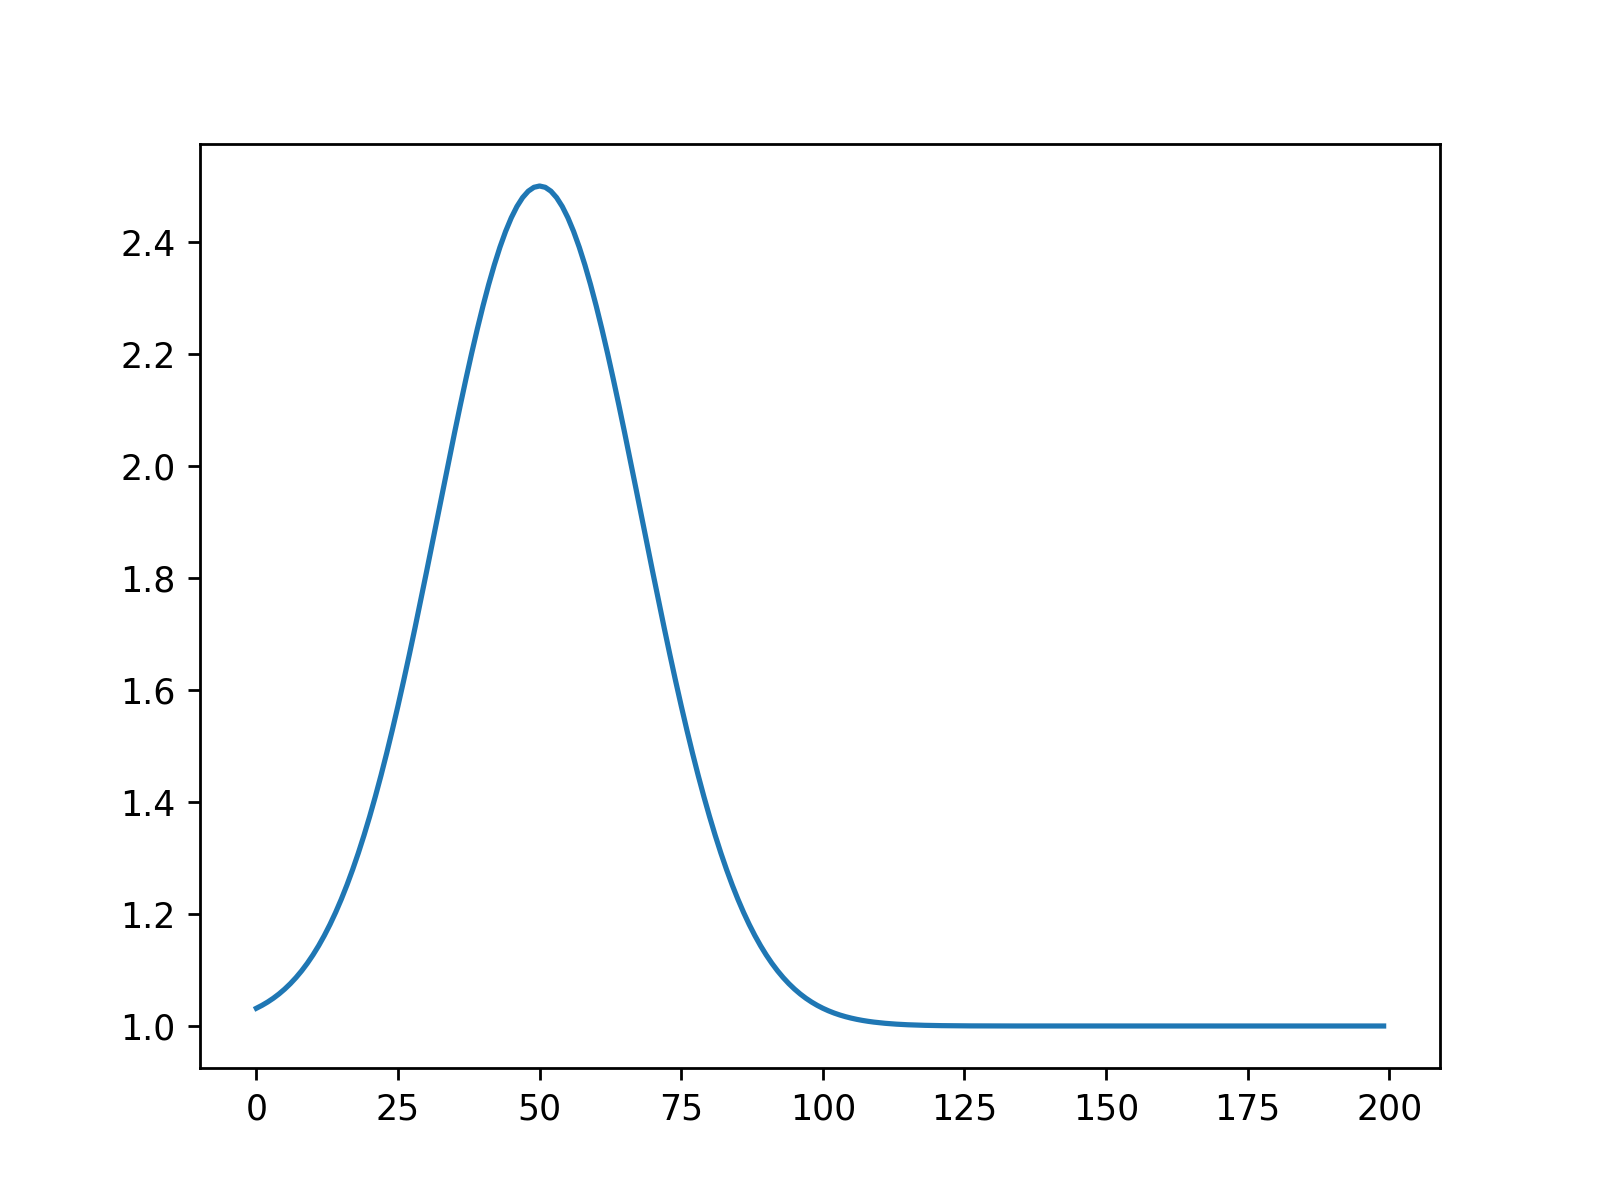

In [146]:
place1_weights = get_place_cell_weights(track_length / 4., 1.2 * field_width, peak_locs, 1., 2.5)
plt.figure()
plt.plot(peak_locs, place1_weights)

In [147]:
dW_dt_matrix_2 = np.empty_like(pre_rate_in_time_matrix)
for i, signal_overlap in enumerate(signal_overlap_matrix):
    dW_dt_matrix_2[i,:] = dW_dt(signal_overlap, place1_weights[i], W_max)

<IPython.core.display.Javascript object>


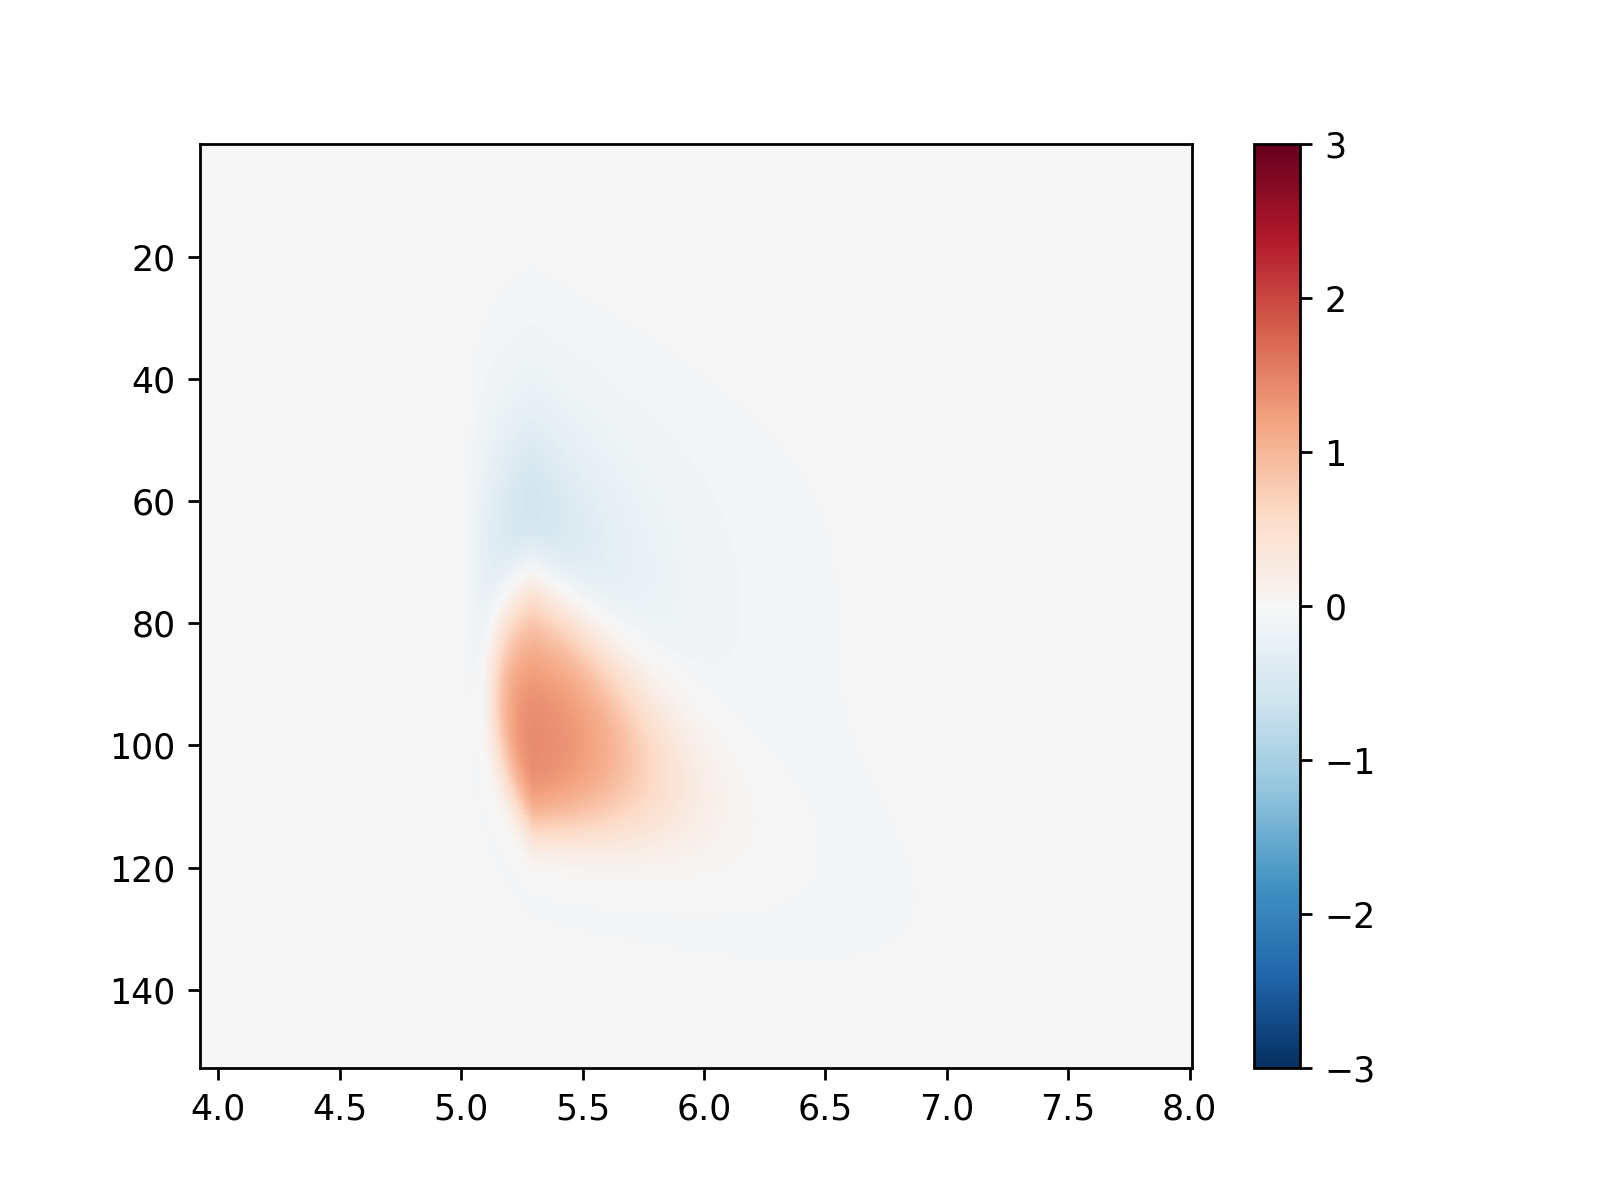

In [148]:
plt.figure()
plt.imshow(dW_dt_matrix_2, cmap='RdBu_r', aspect='auto', extent=[-duration, 2. * duration, num_inputs-1, 0], vmin=-W_max, vmax=W_max)
plt.colorbar()

In [149]:
place2_delta_weights = np.empty_like(silent_weights)
for i, this_dW_dt in enumerate(dW_dt_matrix_2):
    place2_delta_weights[i] = np.trapz(this_dW_dt, dx=dt)

<IPython.core.display.Javascript object>


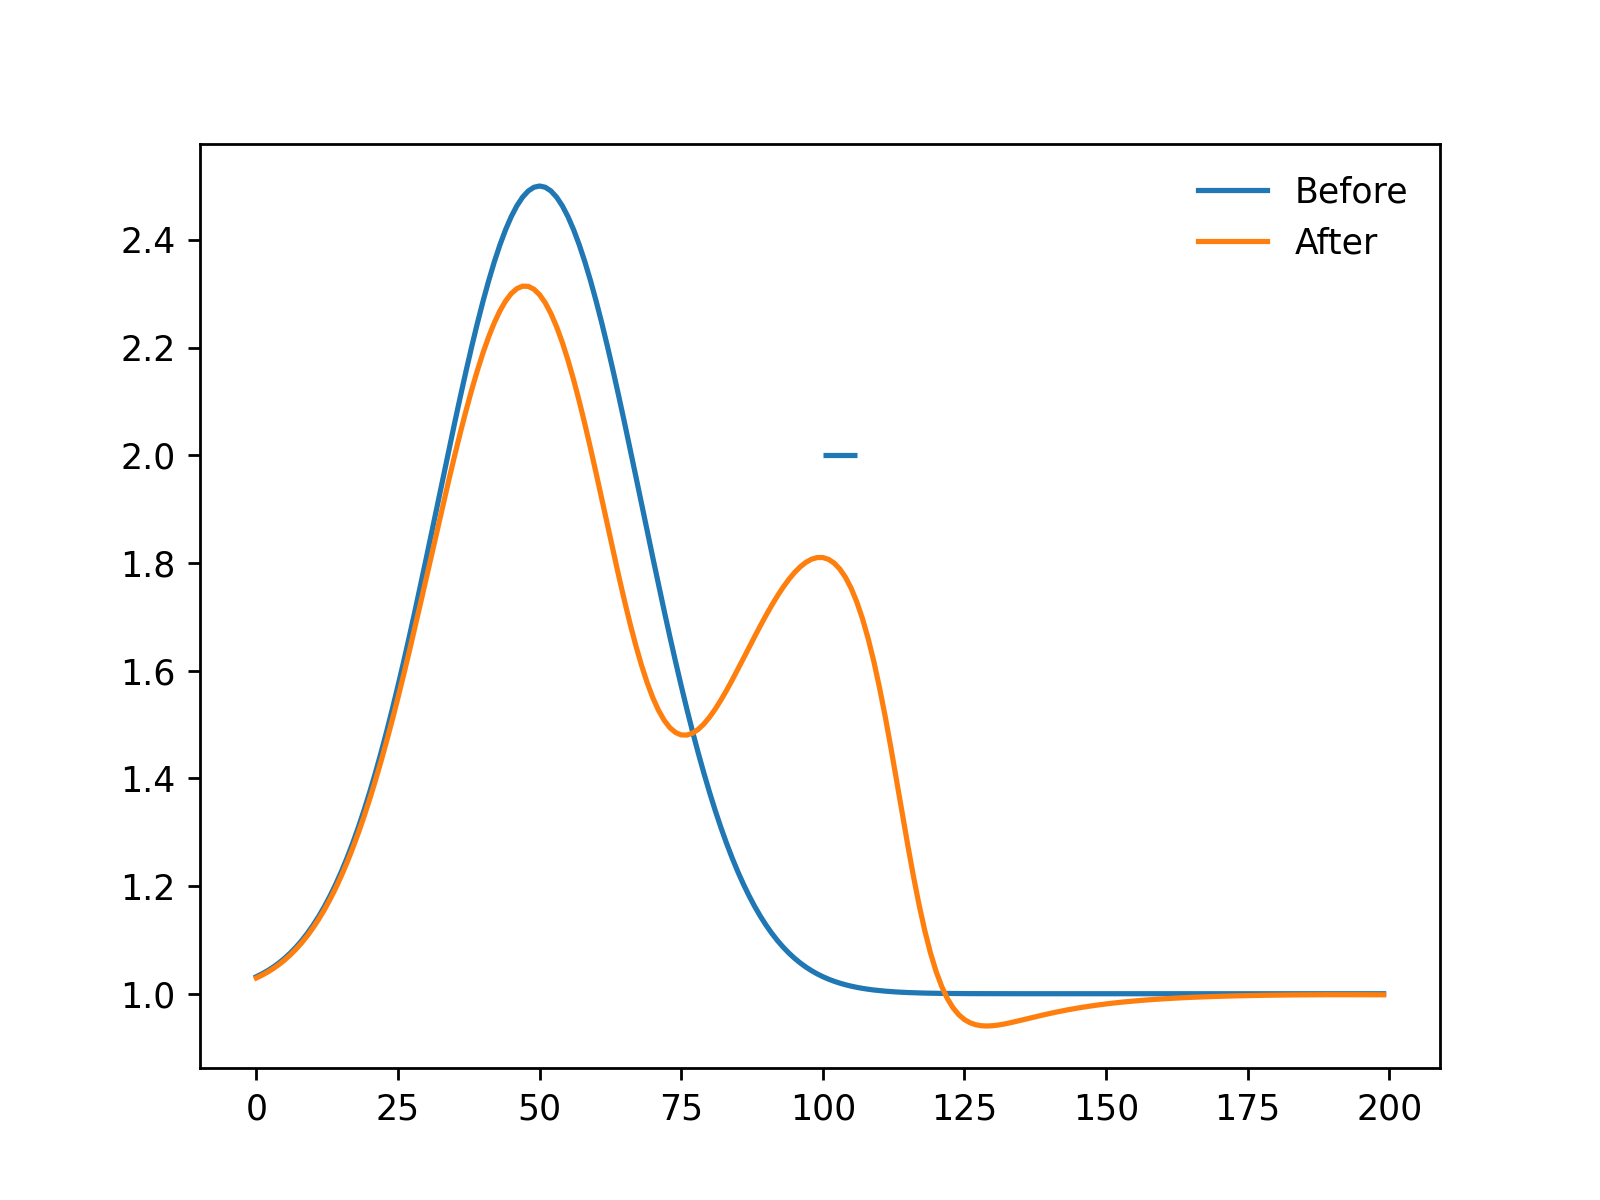

In [150]:
plt.figure()
plt.plot(peak_locs, place1_weights, label='Before')
plt.plot(peak_locs, place1_weights + place2_delta_weights, label='After')
plt.hlines(y=2., xmin=plateau_loc, xmax=plateau_loc + plateau_duration * run_vel)
plt.legend(loc='best', frameon=False)